In [1]:
import os
import pickle
import sys

# uncomment and replace with correct path if there are import errors
sys.path.append("/home/dux/surface_sampling/")
sys.path.append("/home/dux/NeuralForceField/")
os.environ["LAMMPS_POTENTIALS"] = "/home/jurgis/lammps/potentials/"
os.environ["LAMMPS_COMMAND"] ="/home/jurgis/lammps/src/lmp_serial"
os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from time import perf_counter


Initialize test slab and parameters

In [2]:
# Load prepared pristine slab
adsorbates = ["Sr", "Ti", "O"]
chem_pot = [-2, 0, 0] # in eV, 1 entry for each chempot

element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)

surface_name = 'SrTiO3(001)'
alpha = 1 # no annealing
temp = 1.0 # in terms of kbT
num_sweeps = 10 # can adjust

Obtain adsorption sites

In [3]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)
sites = site_finder.find_adsorption_sites(
    distance=1.55, put_inside=False, symm_reduce=False, no_obtuse_hollow=False
)
ads_positions = sites['all']
print("adsorption coordinates are")
print(ads_positions)

adsorption coordinates are
[array([-1.20427451e-05, -2.92606645e-02,  1.88703535e+01]), array([ 1.96776177,  1.95126006, 18.82924596]), array([ 1.96778444,  0.14564931, 18.78214629]), array([-1.20427451e-05,  3.95573460e+00,  1.88703535e+01]), array([ 1.96776177,  5.93625532, 18.82924596]), array([ 1.96778444,  4.13064457, 18.78214629]), array([ 3.93552559, -0.02926066, 18.8703535 ]), array([ 5.9032994 ,  1.95126006, 18.82924596]), array([ 5.90332207,  0.14564931, 18.78214629]), array([ 3.93552559,  3.9557346 , 18.8703535 ]), array([ 5.9032994 ,  5.93625532, 18.82924596]), array([ 5.90332207,  4.13064457, 18.78214629]), array([ 9.83884836, 30.93591913, 18.80569613]), array([ 8.85495012, 30.84846415, 18.84979973]), array([29.51653651, 30.93591913, 18.80569613]), array([30.50040709, 30.84846415, 18.84979973]), array([14.7582679 , 15.99817536, 18.8262499 ]), array([15.74214348, 13.90624584, 18.82924596]), array([30.50040709, 28.85596652, 18.84979973]), array([ 8.85495012, 28.85596652, 18.

Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039).

In [4]:
import torch
from nff.io import NeuralFF, AtomsBatch, EnsembleNFF 

if torch.cuda.is_available():
    DEVICE = 0
else:
    DEVICE = "cpu"

nnids = ['model01', 'model02', 'model03']
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_calc = EnsembleNFF(models, device=DEVICE)

# set attributes
CUTOFF = 5
relax = True
relax_steps = 5
optimizer = "BFGS"
offset = True
offset_data = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

slab_batch = AtomsBatch(
    positions=slab.positions,
    numbers=slab.numbers,
    cell=slab.cell,
    pbc=True,
    cutoff=CUTOFF,
    props={"energy": 0, "energy_grad": []},
    calculator=nff_calc,
    requires_large_offsets=True,
    directed=True,
    device=DEVICE,
    )

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

c = FixAtoms(indices=fix_indices)
slab_batch.set_constraint(c)

bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2023-05-20 12:39:12,871|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1
2023-05-20 12:39:12,873|INFO|using slab calc <nff.io.ase.EnsembleNFF object at 0x7fee4b245bb0>
2023-05-20 12:39:12,874|INFO|there are 60 atoms in pristine slab
2023-05-20 12:39:12,875|INFO|adsorbate(s) is(are) ['Sr', 'Ti', 'O']
2023-05-20 12:39:12,876|INFO|In pristine slab, there are a total of 72 sites
2023-05-20 12:39:13,607|INFO|running for 72 iterations per run over a total of 10 runs
2023-05-20 12:39:13,609|INFO|In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:39:13       10.371862        2.9750
BFGS:    1 12:39:13       10.179447        1.9596
BFGS:    2 12:39:13        9.971385        0.9147
BFGS:    3 12:39:14        9.931394        0.7653
BFGS:    4 12:39:14        9.905395        0.6114
BFGS:    5 12:39:14        9.892407        0.4885
      Step     Time          Energy         fmax
BFGS:    0 12:39:14       -0.563097        4.1297
BFGS:    1 12:39:14       -1.124515        2.2631
BFGS:    2 12:39:14       -1.672873        2.0102
BFGS:    3 12:39:14       -1.907091        2.4014
BFGS:    4 12:39:14       -2.609812        2.5474
BFGS:    5 12:39:14       -2.954953        2.9915
      Step     Time          Energy         fmax
BFGS:    0 12:39:15      -11.561534        4.8163
BFGS:    1 12:39:15      -12.373227        3.1330
BFGS:    2 12:39:15      -12.847768        1.2214
BFGS:    3 12:39:15      -12.944119        1.1047
BFGS:    4 12:39:15      -13.272945        0.9090
BFG

2023-05-20 12:39:20,552|INFO|encountered energy out of bounds
2023-05-20 12:39:20,554|INFO|energy 1406.959
2023-05-20 12:39:20,554|INFO|encountered energy or forces out of bounds
2023-05-20 12:39:20,555|INFO|max_force 24658.256, energy 245.633
2023-05-20 12:39:20,555|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:39:20       -0.815366        2.7597
BFGS:    1 12:39:20       -1.312927        2.2019
BFGS:    2 12:39:20       -1.876660        1.9881
BFGS:    3 12:39:21       -2.084406        2.3697
BFGS:    4 12:39:21       -2.713600        2.2885
BFGS:    5 12:39:21       -2.976892        3.3620
      Step     Time          Energy         fmax
BFGS:    0 12:39:21       -7.822746        5.1541
BFGS:    1 12:39:21       -8.991996        3.1252
BFGS:    2 12:39:21      -10.199070        4.2986
BFGS:    3 12:39:21      -10.619776        2.3645
BFGS:    4 12:39:22      -11.229621        1.5742
BFGS:    5 12:39:22      -11.394367        1.0305
      Step     Time          Energy         fmax
BFGS:    0 12:39:22       -9.975924       12.4004
BFGS:    1 12:39:22      -12.624638        3.3010
BFGS:    2 12:39:22      -13.626557        3.0351
BFGS:    3 12:39:22      -14.523137        4.1805
BFGS:    4 12:39:22      -14.973262        2.3873
BFG

2023-05-20 12:39:33,063|INFO|encountered energy out of bounds
2023-05-20 12:39:33,064|INFO|energy 309997.906
2023-05-20 12:39:33,065|INFO|encountered energy or forces out of bounds
2023-05-20 12:39:33,065|INFO|max_force 6702130.000, energy 258.230
2023-05-20 12:39:33,066|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:39:33       -1.549726       72.0307
BFGS:    1 12:39:33      -18.671303       33.8435
BFGS:    2 12:39:33      -31.895851       10.3061
BFGS:    3 12:39:33      -39.067257        4.7694
BFGS:    4 12:39:33      -42.276245        3.3534
BFGS:    5 12:39:33      -44.137707        3.3125
      Step     Time          Energy         fmax
BFGS:    0 12:39:34      -12.055120       33.9944
BFGS:    1 12:39:34      -23.735588       18.0828
BFGS:    2 12:39:34      -32.400890       14.2509
BFGS:    3 12:39:34      -38.132248        7.5823
BFGS:    4 12:39:34      -41.467197        6.3419
BFGS:    5 12:39:34      -43.724758        5.0070
      Step     Time          Energy         fmax
BFGS:    0 12:39:35      -21.894499       29.5014
BFGS:    1 12:39:35      -32.109554       10.8826
BFGS:    2 12:39:35      -39.640797        5.2088
BFGS:    3 12:39:35      -43.776287        4.5609
BFGS:    4 12:39:35      -46.159328        4.1079
BFG

2023-05-20 12:39:44,008|INFO|encountered energy out of bounds
2023-05-20 12:39:44,009|INFO|energy 539.561
2023-05-20 12:39:44,010|INFO|encountered energy or forces out of bounds
2023-05-20 12:39:44,011|INFO|max_force 8247.026, energy 231.965
2023-05-20 12:39:44,011|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:39:44       32.169994      130.1674
BFGS:    1 12:39:44        1.028424       40.3649
BFGS:    2 12:39:44      -14.098220       29.2353
BFGS:    3 12:39:44      -24.385742       19.0638
BFGS:    4 12:39:44      -32.944019       13.1000
BFGS:    5 12:39:44      -38.112850       10.0244
      Step     Time          Energy         fmax
BFGS:    0 12:39:44       15.499063       84.1478
BFGS:    1 12:39:44        2.135028       69.7552
BFGS:    2 12:39:45      -17.187860       32.3758
BFGS:    3 12:39:45      -30.468737       21.0236
BFGS:    4 12:39:45      -39.338413       11.4718
BFGS:    5 12:39:45      -45.019329        5.0928
      Step     Time          Energy         fmax
BFGS:    0 12:39:45       -2.599040      101.1845
BFGS:    1 12:39:45       73.260071     1511.4852
BFGS:    2 12:39:45       33.529461      926.5036
BFGS:    3 12:39:45      -12.289515      196.5973
BFGS:    4 12:39:46      -22.086441       57.8840
BFG

2023-05-20 12:39:48,277|INFO|encountered energy out of bounds
2023-05-20 12:39:48,278|INFO|energy 547.043
2023-05-20 12:39:48,279|INFO|encountered energy or forces out of bounds
2023-05-20 12:39:48,279|INFO|max_force 8249.977, energy 228.293
2023-05-20 12:39:48,280|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:39:48       -0.994224       71.8757
BFGS:    1 12:39:48      -17.971533       22.9837
BFGS:    2 12:39:48      -32.028091       10.2946
BFGS:    3 12:39:48      -42.091522        6.3674
BFGS:    4 12:39:49      -47.530903        4.0485
BFGS:    5 12:39:49      -50.340710        2.3891


2023-05-20 12:39:49,389|INFO|encountered energy out of bounds
2023-05-20 12:39:49,390|INFO|energy 34773.789
2023-05-20 12:39:49,392|INFO|encountered energy or forces out of bounds
2023-05-20 12:39:49,392|INFO|max_force 624790.812, energy 254.099
2023-05-20 12:39:49,393|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:39:49       16.842299       72.1874
BFGS:    1 12:39:49        3.518522       20.5994
BFGS:    2 12:39:49       -8.115458        9.3672
BFGS:    3 12:39:50      -16.661921        5.4966
BFGS:    4 12:39:50      -21.193100        3.4955
BFGS:    5 12:39:50      -23.601301        2.3080
      Step     Time          Energy         fmax
BFGS:    0 12:39:50        4.671564       70.4347
BFGS:    1 12:39:50       -9.952367       21.5411
BFGS:    2 12:39:51      -22.021219        9.7747
BFGS:    3 12:39:51      -31.629517        6.7010
BFGS:    4 12:39:51      -37.048553        4.6586
BFGS:    5 12:39:51      -40.378925        3.9762
      Step     Time          Energy         fmax
BFGS:    0 12:39:51        2.075196       68.2888
BFGS:    1 12:39:51      -14.698700       21.1669
BFGS:    2 12:39:51      -27.819931       10.3309
BFGS:    3 12:39:51      -36.465237        7.7030
BFGS:    4 12:39:52      -41.376186        4.8913
BFG

2023-05-20 12:39:54,683|INFO|encountered energy out of bounds
2023-05-20 12:39:54,684|INFO|energy 310248.062
2023-05-20 12:39:54,685|INFO|encountered energy or forces out of bounds
2023-05-20 12:39:54,685|INFO|max_force 6710547.500, energy 228.293
2023-05-20 12:39:54,686|INFO|saving this slab
2023-05-20 12:39:54,765|INFO|encountered energy out of bounds
2023-05-20 12:39:54,767|INFO|energy 365949.219
2023-05-20 12:39:54,768|INFO|encountered energy or forces out of bounds
2023-05-20 12:39:54,769|INFO|max_force 15663371.000, energy 228.293
2023-05-20 12:39:54,770|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:39:54        8.613450       69.7361
BFGS:    1 12:39:55      -11.743446       26.1292
BFGS:    2 12:39:55      -26.195740       13.1398
BFGS:    3 12:39:55      -36.439686        8.0130
BFGS:    4 12:39:55      -43.109829        5.2895
BFGS:    5 12:39:55      -46.946854        3.5989


2023-05-20 12:39:55,732|INFO|encountered energy out of bounds
2023-05-20 12:39:55,734|INFO|energy 386.984
2023-05-20 12:39:55,734|INFO|encountered energy or forces out of bounds
2023-05-20 12:39:55,735|INFO|max_force 5197.430, energy 269.348
2023-05-20 12:39:55,736|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:39:55       37.916214      482.5894
BFGS:    1 12:39:55       15.665999       64.4831
BFGS:    2 12:39:56       -9.951509       58.3245
BFGS:    3 12:39:56      -27.449409       55.2966
BFGS:    4 12:39:56      -38.437096       33.2614
BFGS:    5 12:39:56      -46.278767       16.5121
      Step     Time          Energy         fmax
BFGS:    0 12:39:56       16.406214       71.2446
BFGS:    1 12:39:56       -2.786102       26.6634
BFGS:    2 12:39:56      -17.570705       13.3935
BFGS:    3 12:39:56      -28.530313        8.6084
BFGS:    4 12:39:57      -36.625576        5.7921
BFGS:    5 12:39:57      -40.144718        7.3039
      Step     Time          Energy         fmax
BFGS:    0 12:39:57       38.837467       70.7831
BFGS:    1 12:39:57       15.286404       25.6270
BFGS:    2 12:39:57      214.874207     3612.2213
BFGS:    3 12:39:57       98.705772     1789.2313
BFGS:    4 12:39:57        5.713804      325.5163
BFG

2023-05-20 12:40:00,515|INFO|encountered energy out of bounds
2023-05-20 12:40:00,516|INFO|energy 266.667
2023-05-20 12:40:00,517|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:00,517|INFO|max_force 3639.624, energy 239.870
2023-05-20 12:40:00,518|INFO|saving this slab
2023-05-20 12:40:00,614|INFO|encountered energy out of bounds
2023-05-20 12:40:00,615|INFO|energy 34783.582
2023-05-20 12:40:00,616|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:00,616|INFO|max_force 624800.250, energy 265.676
2023-05-20 12:40:00,617|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:00        9.736439       71.1183
BFGS:    1 12:40:00      -13.889405       28.4637
BFGS:    2 12:40:01      -31.495651       15.1046
BFGS:    3 12:40:01      -43.766048        9.0935
BFGS:    4 12:40:01      -52.500107        5.5855
BFGS:    5 12:40:01      -57.115185        5.8460
      Step     Time          Energy         fmax
BFGS:    0 12:40:01        9.736438       71.1183
BFGS:    1 12:40:01      -13.889405       28.4637
BFGS:    2 12:40:01      -31.495657       15.1046
BFGS:    3 12:40:01      -43.766022        9.0935
BFGS:    4 12:40:01      -52.500134        5.5855
BFGS:    5 12:40:02      -57.115192        5.8460
      Step     Time          Energy         fmax
BFGS:    0 12:40:02        9.736439       71.1183
BFGS:    1 12:40:02      -13.889404       28.4637
BFGS:    2 12:40:02      -31.495657       15.1046
BFGS:    3 12:40:02      -43.766022        9.0935
BFGS:    4 12:40:02      -52.500134        5.5855
BFG

2023-05-20 12:40:02,855|INFO|current energy is 1.6759056624783852, calculated energy is 1.6759056624783852
2023-05-20 12:40:02,857|INFO|optim structure has Free Energy = 11.676+/-0.267
2023-05-20 12:40:02,858|INFO|average force error = 0.057
2023-05-20 12:40:02,874|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:40:02       63.364670      108.8353
BFGS:    1 12:40:03       19.000162       60.0083
BFGS:    2 12:40:03       -9.772004       43.1578
BFGS:    3 12:40:03      -27.819839       16.2342
BFGS:    4 12:40:03      -43.031200       20.3812
BFGS:    5 12:40:03      -53.469898       11.2556


2023-05-20 12:40:03,710|INFO|encountered energy out of bounds
2023-05-20 12:40:03,711|INFO|energy 315.388
2023-05-20 12:40:03,711|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:03,712|INFO|max_force 3626.782, energy 274.040
2023-05-20 12:40:03,712|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:03       14.977860       75.5804
BFGS:    1 12:40:03       -7.531553       29.2125
BFGS:    2 12:40:04      -25.918922       15.6029
BFGS:    3 12:40:04      -38.902065        9.4439
BFGS:    4 12:40:04      -48.146160        5.5518
BFGS:    5 12:40:04      -52.317249        8.3061
      Step     Time          Energy         fmax
BFGS:    0 12:40:04       14.977857       75.5804
BFGS:    1 12:40:04       -7.531550       29.2125
BFGS:    2 12:40:04      -25.918921       15.6029
BFGS:    3 12:40:04      -38.902058        9.4439
BFGS:    4 12:40:04      -48.146152        5.5518
BFGS:    5 12:40:04      -52.317249        8.3061


2023-05-20 12:40:05,088|INFO|encountered energy out of bounds
2023-05-20 12:40:05,088|INFO|energy 1389.100
2023-05-20 12:40:05,090|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:05,090|INFO|max_force 25973.328, energy 270.368
2023-05-20 12:40:05,091|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:05       52.525452       74.3752
BFGS:    1 12:40:05        8.791342       48.6272
BFGS:    2 12:40:05      -10.867520       24.4988
BFGS:    3 12:40:05      -27.286499       11.7476
BFGS:    4 12:40:05      -39.325111        7.9263
BFGS:    5 12:40:05      -47.022518        6.1185
      Step     Time          Energy         fmax
BFGS:    0 12:40:06       62.577728       80.6971
BFGS:    1 12:40:06       19.515917       47.8487
BFGS:    2 12:40:06       -4.296120       19.8391
BFGS:    3 12:40:06      -23.029715       15.9014
BFGS:    4 12:40:06      -35.951000       14.0119
BFGS:    5 12:40:06      -43.393307        5.6974
      Step     Time          Energy         fmax
BFGS:    0 12:40:06       73.591248      125.4365
BFGS:    1 12:40:07       25.269609       45.5030
BFGS:    2 12:40:07       -7.097130       37.5638
BFGS:    3 12:40:07      -28.414816       24.0551
BFGS:    4 12:40:07      -40.810741       15.4166
BFG

2023-05-20 12:40:09,332|INFO|encountered energy out of bounds
2023-05-20 12:40:09,334|INFO|energy 270.356
2023-05-20 12:40:09,336|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:09,337|INFO|max_force 3572.305, energy 280.925
2023-05-20 12:40:09,337|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:09       60.393585      166.4102
BFGS:    1 12:40:09        6.060805       67.4080
BFGS:    2 12:40:09      -18.366413       63.8894
BFGS:    3 12:40:09      -36.621494       39.9065
BFGS:    4 12:40:09      -52.298176       18.7880
BFGS:    5 12:40:09      -59.824875        8.9789
      Step     Time          Energy         fmax
BFGS:    0 12:40:10        5.964911       68.1680
BFGS:    1 12:40:10      -15.828217       32.6800
BFGS:    2 12:40:10      -34.794033       13.4333
BFGS:    3 12:40:10      -48.382141        9.1087
BFGS:    4 12:40:10      -55.831486        4.4956
BFGS:    5 12:40:10      -59.032043        3.9755
      Step     Time          Energy         fmax
BFGS:    0 12:40:10       16.137070       79.4398
BFGS:    1 12:40:11       -3.194410       56.1495
BFGS:    2 12:40:11      -22.914469       18.4651
BFGS:    3 12:40:11      -40.747837       11.0684
BFGS:    4 12:40:11      -52.572582        7.8760
BFG

2023-05-20 12:40:22,575|INFO|encountered energy out of bounds
2023-05-20 12:40:22,580|INFO|energy 546.199
2023-05-20 12:40:22,581|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:22,582|INFO|max_force 8214.731, energy 255.119
2023-05-20 12:40:22,582|INFO|saving this slab
2023-05-20 12:40:22,693|INFO|encountered energy out of bounds
2023-05-20 12:40:22,694|INFO|energy 362.855
2023-05-20 12:40:22,695|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:22,695|INFO|max_force 5165.124, energy 274.040
2023-05-20 12:40:22,695|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:22       33.069073      416.7262
BFGS:    1 12:40:23        6.374668       34.2415
BFGS:    2 12:40:23      -16.637205       16.2723
BFGS:    3 12:40:23      -31.122269        9.2556
BFGS:    4 12:40:23      -40.838985        6.5179
BFGS:    5 12:40:23      -46.392841        5.7776


2023-05-20 12:40:23,870|INFO|encountered energy out of bounds
2023-05-20 12:40:23,873|INFO|energy 309985.031
2023-05-20 12:40:23,874|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:23,875|INFO|max_force 6697421.500, energy 274.040
2023-05-20 12:40:23,875|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:24       30.371687       83.4179
BFGS:    1 12:40:24        4.428432       48.4884
BFGS:    2 12:40:24      -19.073854       21.2679
BFGS:    3 12:40:24      -36.767559       13.7379
BFGS:    4 12:40:24      -47.400105        6.5536
BFGS:    5 12:40:24      -54.125347        5.5010
      Step     Time          Energy         fmax
BFGS:    0 12:40:24       35.154438      100.4777
BFGS:    1 12:40:25        0.414260       31.3052
BFGS:    2 12:40:25      -23.062651       17.7592
BFGS:    3 12:40:25      -37.443653       13.3837
BFGS:    4 12:40:25      -48.181210        9.0601
BFGS:    5 12:40:25      -53.821148        4.9307
      Step     Time          Energy         fmax
BFGS:    0 12:40:25       -7.712881       74.7961
BFGS:    1 12:40:25      -25.729063       24.7240
BFGS:    2 12:40:26      -41.704342       12.5368
BFGS:    3 12:40:26      -53.091217        7.8264
BFGS:    4 12:40:26      -60.332108        5.7402
BFG

2023-05-20 12:40:30,697|INFO|encountered energy out of bounds
2023-05-20 12:40:30,698|INFO|energy 309651.562
2023-05-20 12:40:30,699|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:30,700|INFO|max_force 6721238.000, energy 277.712
2023-05-20 12:40:30,700|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:30       55.545681      402.5780
BFGS:    1 12:40:31       40.722324      103.2222
BFGS:    2 12:40:31        8.820583       59.2422
BFGS:    3 12:40:31      -12.446237       57.0062
BFGS:    4 12:40:31      -33.323566       44.1767
BFGS:    5 12:40:31      -46.426758       26.3807
      Step     Time          Energy         fmax
BFGS:    0 12:40:31       -0.450655       75.0625
BFGS:    1 12:40:31      -20.215021       29.3333
BFGS:    2 12:40:32      -35.966000       15.0296
BFGS:    3 12:40:32      -48.032475        8.2913
BFGS:    4 12:40:32      -55.967983        5.4766
BFGS:    5 12:40:32      -59.833832        3.9163


2023-05-20 12:40:32,502|INFO|encountered energy out of bounds
2023-05-20 12:40:32,503|INFO|energy 35313.500
2023-05-20 12:40:32,506|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:32,506|INFO|max_force 628719.188, energy 255.119
2023-05-20 12:40:32,507|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:32       42.127468      444.1188
BFGS:    1 12:40:32       58.484669       73.3817
BFGS:    2 12:40:32       25.072092       75.0195
BFGS:    3 12:40:32        0.014035      106.9011
BFGS:    4 12:40:33      -25.995352       76.2085
BFGS:    5 12:40:33      -41.648731       38.5113
      Step     Time          Energy         fmax
BFGS:    0 12:40:33       23.482904       88.1594
BFGS:    1 12:40:33      -15.680634       36.4992
BFGS:    2 12:40:33      -31.753189       18.6874
BFGS:    3 12:40:33      -43.363632       14.8560
BFGS:    4 12:40:33      -53.077194       10.1453
BFGS:    5 12:40:33      -58.737366        8.3847
      Step     Time          Energy         fmax
BFGS:    0 12:40:34        3.867764       75.4763
BFGS:    1 12:40:34      -16.053640       29.5226
BFGS:    2 12:40:34      -32.318874       14.8787
BFGS:    3 12:40:34      -44.490597        7.9022
BFGS:    4 12:40:34      -51.515942        3.9754
BFG

2023-05-20 12:40:36,716|INFO|encountered energy out of bounds
2023-05-20 12:40:36,717|INFO|energy 378.728
2023-05-20 12:40:36,718|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:36,719|INFO|max_force 5207.998, energy 280.925
2023-05-20 12:40:36,719|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:36       26.419237      113.0246
BFGS:    1 12:40:36       -4.062330       30.7241
BFGS:    2 12:40:37      -25.186905       14.6190
BFGS:    3 12:40:37      -41.142227       15.7615
BFGS:    4 12:40:37      -52.053940        8.3409
BFGS:    5 12:40:37      -58.990330        5.6776
      Step     Time          Energy         fmax
BFGS:    0 12:40:37       23.391325       73.6658
BFGS:    1 12:40:37       -8.407608       28.7088
BFGS:    2 12:40:37      -32.233372       14.9838
BFGS:    3 12:40:37      -47.964222        9.7951
BFGS:    4 12:40:37      -58.175358        6.9145
BFGS:    5 12:40:37      -64.622780        4.7803
      Step     Time          Energy         fmax
BFGS:    0 12:40:38        4.364994       75.3458
BFGS:    1 12:40:38      -17.491041       27.4622
BFGS:    2 12:40:38      -33.900520       12.8284
BFGS:    3 12:40:38      -46.300720        7.7727
BFGS:    4 12:40:38      -53.885387        5.3365
BFG

2023-05-20 12:40:41,720|INFO|encountered energy out of bounds
2023-05-20 12:40:41,721|INFO|energy 35324.824
2023-05-20 12:40:41,725|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:41,726|INFO|max_force 628434.500, energy 280.925
2023-05-20 12:40:41,726|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:41       -4.204065       71.8943
BFGS:    1 12:40:41      -29.303278       28.8059
BFGS:    2 12:40:42      -47.062656       15.0845
BFGS:    3 12:40:42      -59.172894        8.9948
BFGS:    4 12:40:42      -67.005165        5.3210
BFGS:    5 12:40:42      -71.874367        3.8143
      Step     Time          Energy         fmax
BFGS:    0 12:40:42        9.147264       74.6966
BFGS:    1 12:40:42      -10.639534       29.1733
BFGS:    2 12:40:42      -26.204712       14.6271
BFGS:    3 12:40:42      -38.687485        7.8357
BFGS:    4 12:40:42      -46.818970        5.2672
BFGS:    5 12:40:43      -51.370777        3.9696
      Step     Time          Energy         fmax
BFGS:    0 12:40:43       49.914059       72.6397
BFGS:    1 12:40:43       -3.941799       79.7392
BFGS:    2 12:40:43      -25.553169       21.4036
BFGS:    3 12:40:43      -41.504185       11.1179
BFGS:    4 12:40:43      -53.228283        7.6893
BFG

2023-05-20 12:40:54,968|INFO|current energy is -1.7583617071595654, calculated energy is -1.7583617071595654
2023-05-20 12:40:54,970|INFO|optim structure has Free Energy = 8.242+/-0.182
2023-05-20 12:40:54,971|INFO|average force error = 0.053
2023-05-20 12:40:54,994|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:40:55       -6.535270       75.5835
BFGS:    1 12:40:55      -20.713987       22.6359
BFGS:    2 12:40:55      -34.573261        9.7856
BFGS:    3 12:40:55      -46.165146        7.0390
BFGS:    4 12:40:55      -52.496708        4.9420
BFGS:    5 12:40:55      -56.120075        3.7271


2023-05-20 12:40:55,897|INFO|encountered energy out of bounds
2023-05-20 12:40:55,898|INFO|energy 272.059
2023-05-20 12:40:55,899|INFO|encountered energy or forces out of bounds
2023-05-20 12:40:55,899|INFO|max_force 3595.976, energy 277.712
2023-05-20 12:40:55,900|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:40:56       15.403835       76.4722
BFGS:    1 12:40:56       13.097869      189.2058
BFGS:    2 12:40:56      -19.107412       27.3567
BFGS:    3 12:40:56      -28.524210      196.1947
BFGS:    4 12:40:56      -42.033325       81.4400
BFGS:    5 12:40:56      -50.411434       29.5648
      Step     Time          Energy         fmax
BFGS:    0 12:40:56        7.587292       74.8240
BFGS:    1 12:40:57      -15.890831       28.8261
BFGS:    2 12:40:57      -34.176323       15.3035
BFGS:    3 12:40:57      -46.641529        8.6887
BFGS:    4 12:40:57      -55.104675        5.9424
BFGS:    5 12:40:57      -59.423946        4.1632
      Step     Time          Energy         fmax
BFGS:    0 12:40:57        3.326629       76.8822
BFGS:    1 12:40:57      -14.364056       24.4730
BFGS:    2 12:40:57      -31.566072       12.0617
BFGS:    3 12:40:58      -44.827633        7.5722
BFGS:    4 12:40:58      -52.974060        5.0894
BFG

2023-05-20 12:41:03,199|INFO|encountered energy out of bounds
2023-05-20 12:41:03,201|INFO|energy 677.791
2023-05-20 12:41:03,202|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:03,203|INFO|max_force 10092.187, energy 255.119
2023-05-20 12:41:03,204|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:03       49.079025      420.4896
BFGS:    1 12:41:03       44.677990      447.0965
BFGS:    2 12:41:03       13.680519       30.9644
BFGS:    3 12:41:03      -11.894662       15.2382
BFGS:    4 12:41:03      -28.460749       11.5323
BFGS:    5 12:41:03      -39.427986        9.5875
      Step     Time          Energy         fmax
BFGS:    0 12:41:03       23.354879      111.9607
BFGS:    1 12:41:04      914.062317    16339.7645
BFGS:    2 12:41:04      457.779816     7839.0798
BFGS:    3 12:41:04       60.025372     1182.0417
BFGS:    4 12:41:04       -6.930273      248.3113
BFGS:    5 12:41:04      -16.803247      174.0351
      Step     Time          Energy         fmax
BFGS:    0 12:41:04       17.078102       76.7529
BFGS:    1 12:41:04       -5.759534       23.8166
BFGS:    2 12:41:04      -27.625946       12.3315
BFGS:    3 12:41:05      -41.510082        8.0715
BFGS:    4 12:41:05      -50.752514        6.0339
BFG

2023-05-20 12:41:06,290|INFO|encountered energy out of bounds
2023-05-20 12:41:06,294|INFO|energy 374.012
2023-05-20 12:41:06,296|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:06,297|INFO|max_force 5155.974, energy 280.925
2023-05-20 12:41:06,298|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:06       83.590355      118.9009
BFGS:    1 12:41:06       40.494572       92.2924
BFGS:    2 12:41:06       16.174330       27.6536
BFGS:    3 12:41:07       -6.488924       26.7737
BFGS:    4 12:41:07       19.174257      733.4358
BFGS:    5 12:41:07      -22.219072      207.6041
      Step     Time          Energy         fmax
BFGS:    0 12:41:07       26.772490       78.2832
BFGS:    1 12:41:07       -0.853099       25.2497
BFGS:    2 12:41:08      -21.940353       11.0374
BFGS:    3 12:41:08      -37.609268        7.6205
BFGS:    4 12:41:08      -46.097260        4.9527
BFGS:    5 12:41:08      -50.296459        4.0265
      Step     Time          Energy         fmax
BFGS:    0 12:41:08       45.768185      432.9292
BFGS:    1 12:41:09       11.956802       35.5054
BFGS:    2 12:41:09      -15.446788       15.5662
BFGS:    3 12:41:09      -33.235424       14.1692
BFGS:    4 12:41:09      -42.884212       10.1998
BFG

2023-05-20 12:41:12,338|INFO|encountered energy out of bounds
2023-05-20 12:41:12,343|INFO|energy 1388.516
2023-05-20 12:41:12,344|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:12,344|INFO|max_force 25774.389, energy 274.040
2023-05-20 12:41:12,345|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:12       59.003460      443.8310
BFGS:    1 12:41:12       31.549517       72.0150
BFGS:    2 12:41:12        4.438642       42.1489
BFGS:    3 12:41:12      -15.323552       32.5333
BFGS:    4 12:41:12      -32.365856       27.7166
BFGS:    5 12:41:12      -44.550755       14.3822
      Step     Time          Energy         fmax
BFGS:    0 12:41:13        5.450713       74.9087
BFGS:    1 12:41:13       -3.571208       50.2019
BFGS:    2 12:41:13      -27.410742       25.5332
BFGS:    3 12:41:13      -46.598957       19.8678
BFGS:    4 12:41:13      -58.948669        7.7058
BFGS:    5 12:41:13      -66.854500        5.1563
      Step     Time          Energy         fmax
BFGS:    0 12:41:14        8.364340       76.1266
BFGS:    1 12:41:14      -18.773436       27.0021
BFGS:    2 12:41:14      -39.997482       14.5713
BFGS:    3 12:41:14      -53.620861       10.1895
BFGS:    4 12:41:14      -61.194584        5.7762
BFG

2023-05-20 12:41:15,607|INFO|encountered energy out of bounds
2023-05-20 12:41:15,608|INFO|energy 35319.879
2023-05-20 12:41:15,609|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:15,610|INFO|max_force 628321.438, energy 274.040
2023-05-20 12:41:15,610|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:15       11.711652       76.2624
BFGS:    1 12:41:15       -7.563687       24.3769
BFGS:    2 12:41:16      -26.244379       12.1554
BFGS:    3 12:41:16      -38.551708        7.5995
BFGS:    4 12:41:16      -45.185719        7.3072
BFGS:    5 12:41:16      -48.973598        4.7465


2023-05-20 12:41:16,448|INFO|encountered energy out of bounds
2023-05-20 12:41:16,449|INFO|energy 256.697
2023-05-20 12:41:16,450|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:16,451|INFO|max_force 3635.737, energy 255.119
2023-05-20 12:41:16,451|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:16       17.399857       75.7315
BFGS:    1 12:41:16      575.483459     9876.7800
BFGS:    2 12:41:16      379.020599     6425.1266
BFGS:    3 12:41:17       66.692551     1332.9749
BFGS:    4 12:41:17      -14.202580       95.2872
BFGS:    5 12:41:17      -26.954834       69.3314


2023-05-20 12:41:17,521|INFO|encountered energy out of bounds
2023-05-20 12:41:17,522|INFO|energy 1389.392
2023-05-20 12:41:17,523|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:17,524|INFO|max_force 25843.256, energy 274.040
2023-05-20 12:41:17,524|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:17       35.359501      120.6837
BFGS:    1 12:41:17       19.680624       28.9773
BFGS:    2 12:41:18      -11.594907       25.8217
BFGS:    3 12:41:18      -27.721130       13.3141
BFGS:    4 12:41:18      -40.506870        7.4937
BFGS:    5 12:41:18      -48.332783        4.7588
      Step     Time          Energy         fmax
BFGS:    0 12:41:18      123.977440      129.2494
BFGS:    1 12:41:18       63.440308      140.2726
BFGS:    2 12:41:18       21.440779       77.6849
BFGS:    3 12:41:18      -10.419187       49.5100
BFGS:    4 12:41:18      -32.542667       25.2286
BFGS:    5 12:41:18      -45.043427       13.6233


2023-05-20 12:41:19,059|INFO|encountered energy out of bounds
2023-05-20 12:41:19,059|INFO|energy 366.660
2023-05-20 12:41:19,060|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:19,061|INFO|max_force 5158.871, energy 274.040
2023-05-20 12:41:19,061|INFO|saving this slab
2023-05-20 12:41:19,150|INFO|encountered energy out of bounds
2023-05-20 12:41:19,153|INFO|energy 684.584
2023-05-20 12:41:19,154|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:19,154|INFO|max_force 10063.004, energy 274.040
2023-05-20 12:41:19,155|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:19       19.078590       77.3774
BFGS:    1 12:41:19       -4.375973       24.4931
BFGS:    2 12:41:19      -23.112680       12.0817
BFGS:    3 12:41:19      -37.654850        7.7238
BFGS:    4 12:41:19      -45.940601        5.5943
BFGS:    5 12:41:19      -49.641163        4.5532
      Step     Time          Energy         fmax
BFGS:    0 12:41:20        4.678321       77.3483
BFGS:    1 12:41:20      -10.338267       24.0187
BFGS:    2 12:41:20      -26.094637       11.3770
BFGS:    3 12:41:20      -38.766415        6.9792
BFGS:    4 12:41:20      -46.432087        4.3077
BFGS:    5 12:41:20      -50.329166        2.9898
      Step     Time          Energy         fmax
BFGS:    0 12:41:21       22.750542       76.3969
BFGS:    1 12:41:21        5.058242       23.6582
BFGS:    2 12:41:21      -11.363952       10.9962
BFGS:    3 12:41:21      -23.123209        6.7537
BFGS:    4 12:41:21      -30.209450        4.9826
BFG

2023-05-20 12:41:21,769|INFO|encountered energy out of bounds
2023-05-20 12:41:21,770|INFO|energy 1420.902
2023-05-20 12:41:21,770|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:21,771|INFO|max_force 25349.697, energy 280.925
2023-05-20 12:41:21,771|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:21       11.479244       77.4512
BFGS:    1 12:41:21       -6.821106       24.8813
BFGS:    2 12:41:22      -25.142256       12.0504
BFGS:    3 12:41:22      -38.604305        6.9985
BFGS:    4 12:41:22      -46.471920        5.7766
BFGS:    5 12:41:22      -50.176525        4.1090
      Step     Time          Energy         fmax
BFGS:    0 12:41:22       23.035833       83.6312
BFGS:    1 12:41:22       -0.193137      118.4664
BFGS:    2 12:41:22       -9.724339       20.6424
BFGS:    3 12:41:22      -26.289429       16.5679
BFGS:    4 12:41:23      -42.446445       31.5650
BFGS:    5 12:41:23      -52.859699        7.9248
      Step     Time          Energy         fmax
BFGS:    0 12:41:23       26.743408      189.6026
BFGS:    1 12:41:23      942.458801    16619.8859
BFGS:    2 12:41:23      327.150726     5650.6785
BFGS:    3 12:41:23       20.066494      701.7107
BFGS:    4 12:41:23      -18.489111      283.9729
BFG

2023-05-20 12:41:26,427|INFO|encountered energy out of bounds
2023-05-20 12:41:26,427|INFO|energy 283.293
2023-05-20 12:41:26,428|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:26,429|INFO|max_force 3595.598, energy 274.040
2023-05-20 12:41:26,430|INFO|saving this slab
2023-05-20 12:41:26,508|INFO|encountered energy out of bounds
2023-05-20 12:41:26,509|INFO|energy 283.293
2023-05-20 12:41:26,510|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:26,510|INFO|max_force 3595.598, energy 274.040
2023-05-20 12:41:26,511|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:26       19.607994       75.6525
BFGS:    1 12:41:26        1.428402       22.8896
BFGS:    2 12:41:26      -16.457823       11.3611
BFGS:    3 12:41:27      -30.693428       11.7660
BFGS:    4 12:41:27      -39.532444        5.8469
BFGS:    5 12:41:27      -45.267551        6.4707
      Step     Time          Energy         fmax
BFGS:    0 12:41:27       30.905005       78.7424
BFGS:    1 12:41:27      131.742935     2208.1882
BFGS:    2 12:41:27       53.579235     1157.9464
BFGS:    3 12:41:27        3.551552      448.1932
BFGS:    4 12:41:27      -20.056433      256.2448
BFGS:    5 12:41:28      -36.734409      134.7150


2023-05-20 12:41:28,277|INFO|encountered energy out of bounds
2023-05-20 12:41:28,278|INFO|energy 310383.219
2023-05-20 12:41:28,278|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:28,279|INFO|max_force 6713465.500, energy 255.119
2023-05-20 12:41:28,279|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:28       25.012766       92.1477
BFGS:    1 12:41:28       -0.432407       31.1531
BFGS:    2 12:41:28      -19.506266       16.4889
BFGS:    3 12:41:28      -34.565876        8.6798
BFGS:    4 12:41:28      -45.976028        8.7200
BFGS:    5 12:41:28      -52.418804        6.3232
      Step     Time          Energy         fmax
BFGS:    0 12:41:29       20.139465       76.8310
BFGS:    1 12:41:29        3.298690       26.3972
BFGS:    2 12:41:29      -11.370442       11.7364
BFGS:    3 12:41:29      -24.539566        5.7692
BFGS:    4 12:41:29      -31.780340        4.2275
BFGS:    5 12:41:29      -34.641285        3.9318
      Step     Time          Energy         fmax
BFGS:    0 12:41:30      102.903252      157.1858
BFGS:    1 12:41:30       77.083595      714.1261
BFGS:    2 12:41:30       37.032063      235.9205
BFGS:    3 12:41:30       37.182682      305.7742
BFGS:    4 12:41:30       10.441582      124.2402
BFG

2023-05-20 12:41:35,071|INFO|encountered energy out of bounds
2023-05-20 12:41:35,072|INFO|energy 700.550
2023-05-20 12:41:35,073|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:35,073|INFO|max_force 10073.429, energy 255.119
2023-05-20 12:41:35,073|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:35       35.426846       76.9053
BFGS:    1 12:41:35        8.620594       34.7568
BFGS:    2 12:41:35       -7.088440       49.7290
BFGS:    3 12:41:35      -13.581800       48.7058
BFGS:    4 12:41:35      -27.137596       60.2341
BFGS:    5 12:41:35      -36.507427       10.0495
      Step     Time          Energy         fmax
BFGS:    0 12:41:36       87.251183      487.2273
BFGS:    1 12:41:36      111.788765      945.6260
BFGS:    2 12:41:36       45.933056      139.7050
BFGS:    3 12:41:36       15.636082      100.9519
BFGS:    4 12:41:36        1.123305       73.9526
BFGS:    5 12:41:36      -16.621531       35.0829
      Step     Time          Energy         fmax
BFGS:    0 12:41:36       24.686960       76.8884
BFGS:    1 12:41:36        8.221242       26.1412
BFGS:    2 12:41:36       -5.889170       11.1727
BFGS:    3 12:41:37      -18.772247        5.7265
BFGS:    4 12:41:37      -26.073624        3.6705
BFG

2023-05-20 12:41:39,169|INFO|encountered energy out of bounds
2023-05-20 12:41:39,170|INFO|energy 1451.076
2023-05-20 12:41:39,170|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:39,171|INFO|max_force 25550.600, energy 236.198
2023-05-20 12:41:39,172|INFO|saving this slab
2023-05-20 12:41:39,245|INFO|encountered energy out of bounds
2023-05-20 12:41:39,246|INFO|energy 694.437
2023-05-20 12:41:39,247|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:39,248|INFO|max_force 10089.667, energy 236.198
2023-05-20 12:41:39,248|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:39       27.947569      179.3505
BFGS:    1 12:41:39     1339.092651    24202.5123
BFGS:    2 12:41:39      470.826416     8150.2977
BFGS:    3 12:41:39       47.743717      906.7290
BFGS:    4 12:41:39        5.619798      201.9431
BFGS:    5 12:41:39      -11.248652      134.6416
      Step     Time          Energy         fmax
BFGS:    0 12:41:40       58.807026      132.4789
BFGS:    1 12:41:40       17.460993       40.2715
BFGS:    2 12:41:40       -1.991832       28.9578
BFGS:    3 12:41:40      -15.727890       19.3745
BFGS:    4 12:41:40      -25.889429        9.2606
BFGS:    5 12:41:40      -32.445358        6.1856
      Step     Time          Energy         fmax
BFGS:    0 12:41:40       25.228060       76.8039
BFGS:    1 12:41:40        8.092956       26.2073
BFGS:    2 12:41:40       -6.857117       11.4483
BFGS:    3 12:41:41      -19.683311        5.5063
BFGS:    4 12:41:41      -25.853468        5.5711
BFG

2023-05-20 12:41:42,713|INFO|current energy is 7.848617213799685, calculated energy is 7.848594325616091
2023-05-20 12:41:42,714|INFO|optim structure has Free Energy = 15.849+/-0.268
2023-05-20 12:41:42,714|INFO|average force error = 0.066
2023-05-20 12:41:42,724|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:41:42       67.007462      117.8123
BFGS:    1 12:41:42       41.412701       48.9157
BFGS:    2 12:41:43       19.775803       24.6939
BFGS:    3 12:41:43        4.531767       31.2274
BFGS:    4 12:41:43       -9.211017       17.8793
BFGS:    5 12:41:43      -18.499590       11.2672
      Step     Time          Energy         fmax
BFGS:    0 12:41:43       31.104187       76.9015
BFGS:    1 12:41:43        9.687760       25.8161
BFGS:    2 12:41:44       -8.830409       11.7618
BFGS:    3 12:41:44      -21.756941        5.7747
BFGS:    4 12:41:44      -28.863558        5.0373
BFGS:    5 12:41:44      -32.357758        3.6182
      Step     Time          Energy         fmax
BFGS:    0 12:41:44       56.318684      128.2471
BFGS:    1 12:41:44       40.477253       37.5764
BFGS:    2 12:41:44       11.848325       19.2515
BFGS:    3 12:41:44       -9.003173       14.6806
BFGS:    4 12:41:45      -17.459299        6.6393
BFG

2023-05-20 12:41:47,870|INFO|encountered energy out of bounds
2023-05-20 12:41:47,872|INFO|energy -2380283.750
2023-05-20 12:41:47,873|INFO|encountered energy or forces out of bounds
2023-05-20 12:41:47,874|INFO|max_force 223074000.000, energy 232.526
2023-05-20 12:41:47,875|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:41:48       30.309378       79.7585
BFGS:    1 12:41:48       10.133873       25.5636
BFGS:    2 12:41:48       -8.890788       12.5543
BFGS:    3 12:41:48      -21.922689        6.4344
BFGS:    4 12:41:48      -29.600008        4.7419
BFGS:    5 12:41:48      -33.341400        4.0817
      Step     Time          Energy         fmax
BFGS:    0 12:41:49      117.039726       94.0849
BFGS:    1 12:41:49       59.069065      155.4278
BFGS:    2 12:41:49       30.463312       58.9381
BFGS:    3 12:41:49       13.947849       29.8987
BFGS:    4 12:41:49        6.010892       75.3077
BFGS:    5 12:41:49      -11.400520       50.7127
      Step     Time          Energy         fmax
BFGS:    0 12:41:50       61.047836      124.1306
BFGS:    1 12:41:50       27.197447       37.9930
BFGS:    2 12:41:50        3.730351       28.4223
BFGS:    3 12:41:50      -10.207097       17.8155
BFGS:    4 12:41:50      -22.364428       12.2370
BFG

2023-05-20 12:42:04,338|INFO|encountered energy out of bounds
2023-05-20 12:42:04,340|INFO|energy 310358.812
2023-05-20 12:42:04,342|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:04,342|INFO|max_force 6700147.500, energy 239.870
2023-05-20 12:42:04,343|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:04       30.143244       73.5789
BFGS:    1 12:42:04       14.196401       31.2944
BFGS:    2 12:42:04       -4.225007       16.8799
BFGS:    3 12:42:04      -15.882935       11.1735
BFGS:    4 12:42:04      -22.963434        6.2715
BFGS:    5 12:42:04      -27.052794        4.3903
      Step     Time          Energy         fmax
BFGS:    0 12:42:05       83.226723       73.2691
BFGS:    1 12:42:05       35.722103      102.5316
BFGS:    2 12:42:05       10.286616       29.9198
BFGS:    3 12:42:05       -6.187268       22.8502
BFGS:    4 12:42:05      -19.122698       13.2355
BFGS:    5 12:42:05      -26.962891        7.1427
      Step     Time          Energy         fmax
BFGS:    0 12:42:06        6.424169       73.4244
BFGS:    1 12:42:06       -6.170498       23.2684
BFGS:    2 12:42:06      -17.074682       10.9300
BFGS:    3 12:42:06      -26.867590        7.2830
BFGS:    4 12:42:06      -31.960657        4.1512
BFG

2023-05-20 12:42:11,113|INFO|encountered energy out of bounds
2023-05-20 12:42:11,114|INFO|energy 673.928
2023-05-20 12:42:11,115|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:11,117|INFO|max_force 10255.109, energy 254.099
2023-05-20 12:42:11,117|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:11        6.264066       67.3759
BFGS:    1 12:42:11      -16.879099       26.1135
BFGS:    2 12:42:11      -30.167521       17.6822
BFGS:    3 12:42:11      -40.839294        8.1821
BFGS:    4 12:42:11      -46.047028        4.7749
BFGS:    5 12:42:11      -49.086792        3.6783
      Step     Time          Energy         fmax
BFGS:    0 12:42:12       12.924579       67.5282
BFGS:    1 12:42:12      -10.333119       25.9144
BFGS:    2 12:42:12      -23.956436       17.6178
BFGS:    3 12:42:12      -35.008770        8.1201
BFGS:    4 12:42:12      -40.386547        4.6474
BFGS:    5 12:42:12      -43.633656        3.6163
      Step     Time          Energy         fmax
BFGS:    0 12:42:12       20.594221       76.3929
BFGS:    1 12:42:13       -6.987244       29.3957
BFGS:    2 12:42:13      -22.766617       12.7955
BFGS:    3 12:42:13      -33.711010        7.3009
BFGS:    4 12:42:13      -40.431137        4.2738
BFG

2023-05-20 12:42:15,472|INFO|encountered energy out of bounds
2023-05-20 12:42:15,474|INFO|energy 692.927
2023-05-20 12:42:15,475|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:15,476|INFO|max_force 10079.763, energy 265.676
2023-05-20 12:42:15,476|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:15       40.580826      202.0685
BFGS:    1 12:42:15      618.460327    10270.3612
BFGS:    2 12:42:16      318.621002     5237.4343
BFGS:    3 12:42:16       50.397396      950.0082
BFGS:    4 12:42:16        6.774699      261.4008
BFGS:    5 12:42:16      -14.814521      212.1759
      Step     Time          Energy         fmax
BFGS:    0 12:42:16       23.447561       74.9935
BFGS:    1 12:42:16       -8.226390       29.3679
BFGS:    2 12:42:16      -28.415487       12.2051
BFGS:    3 12:42:16      -42.875362        7.2298
BFGS:    4 12:42:17      -50.677097        4.4588
BFGS:    5 12:42:17      -54.495152        4.9949


2023-05-20 12:42:17,311|INFO|encountered energy out of bounds
2023-05-20 12:42:17,313|INFO|energy 1435.863
2023-05-20 12:42:17,314|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:17,315|INFO|max_force 25540.838, energy 239.870
2023-05-20 12:42:17,316|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:17       77.594231      137.1430
BFGS:    1 12:42:17       29.730835       71.8394
BFGS:    2 12:42:17        1.572298       37.5182
BFGS:    3 12:42:17      -14.981769       39.9431
BFGS:    4 12:42:17      -30.215796       23.6117
BFGS:    5 12:42:18      -41.652668       11.7439
      Step     Time          Energy         fmax
BFGS:    0 12:42:18       41.633488      103.4907
BFGS:    1 12:42:18       11.895343       36.8167
BFGS:    2 12:42:18      -11.881989       45.0262
BFGS:    3 12:42:18      -24.980803       36.4317
BFGS:    4 12:42:18      -37.861603       15.2700
BFGS:    5 12:42:18      -44.614399        8.6896
      Step     Time          Energy         fmax
BFGS:    0 12:42:19       15.930022       65.8106
BFGS:    1 12:42:19      -17.267420       24.6641
BFGS:    2 12:42:19      -33.710968       20.1154
BFGS:    3 12:42:19      -44.740540        7.1640
BFGS:    4 12:42:19      -51.340977        3.9877
BFG

2023-05-20 12:42:29,761|INFO|encountered energy out of bounds
2023-05-20 12:42:29,762|INFO|energy 310313.500
2023-05-20 12:42:29,763|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:29,763|INFO|max_force 6706140.000, energy 262.004
2023-05-20 12:42:29,764|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:29       47.340000       85.9577
BFGS:    1 12:42:29       13.159782      123.4095
BFGS:    2 12:42:30        3.983685       21.1574
BFGS:    3 12:42:30      -14.797702       20.8367
BFGS:    4 12:42:30      -30.241083       22.8706
BFGS:    5 12:42:30      -38.918301        7.0756
      Step     Time          Energy         fmax
BFGS:    0 12:42:30       47.271915      100.0409
BFGS:    1 12:42:30      180.118362     2744.0373
BFGS:    2 12:42:30       66.024086     1061.5354
BFGS:    3 12:42:30        9.659936      147.0732
BFGS:    4 12:42:31       -8.384776       55.1236
BFGS:    5 12:42:31      -14.244617       65.6919
      Step     Time          Energy         fmax
BFGS:    0 12:42:31       30.221876       76.1609
BFGS:    1 12:42:31        3.030375       28.4460
BFGS:    2 12:42:31      -13.114408       12.3738
BFGS:    3 12:42:31      -24.348946        6.8858
BFGS:    4 12:42:31      -30.773424        4.2095
BFG

2023-05-20 12:42:33,951|INFO|encountered energy out of bounds
2023-05-20 12:42:33,952|INFO|energy 310313.500
2023-05-20 12:42:33,952|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:33,953|INFO|max_force 6706140.000, energy 262.004
2023-05-20 12:42:33,953|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:34       46.069447      132.8130
BFGS:    1 12:42:34        6.016014       38.0203
BFGS:    2 12:42:34      -11.175485       23.8707
BFGS:    3 12:42:34      -24.242651       21.4019
BFGS:    4 12:42:34      -34.962715        8.5649
BFGS:    5 12:42:34      -40.110004        3.9393


2023-05-20 12:42:34,790|INFO|encountered energy out of bounds
2023-05-20 12:42:34,791|INFO|energy 34793.480
2023-05-20 12:42:34,792|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:34,793|INFO|max_force 624642.500, energy 262.004
2023-05-20 12:42:34,793|INFO|saving this slab
2023-05-20 12:42:34,939|INFO|encountered energy out of bounds
2023-05-20 12:42:34,941|INFO|energy 34798.113
2023-05-20 12:42:34,942|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:34,943|INFO|max_force 624699.938, energy 255.119
2023-05-20 12:42:34,943|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:35       19.122065       74.9305
BFGS:    1 12:42:35       -7.690453       27.5188
BFGS:    2 12:42:35      -23.342445       10.3561
BFGS:    3 12:42:35      -35.291264        6.1252
BFGS:    4 12:42:35      -41.244358        3.7067
BFGS:    5 12:42:35      -44.613857        4.3963
      Step     Time          Energy         fmax
BFGS:    0 12:42:36       31.851732       77.2319
BFGS:    1 12:42:36      -10.794899       37.8995
BFGS:    2 12:42:36      -31.724344       21.0820
BFGS:    3 12:42:36      -47.397488       10.4692
BFGS:    4 12:42:36      -56.525806        4.2571
BFGS:    5 12:42:36      -60.263096        4.2763
      Step     Time          Energy         fmax
BFGS:    0 12:42:37       43.870708       71.9085
BFGS:    1 12:42:37       -0.601573       37.5108
BFGS:    2 12:42:37      -23.086092       17.5045
BFGS:    3 12:42:37      -40.005749       10.5725
BFGS:    4 12:42:37      -50.507580        5.6935
BFG

2023-05-20 12:42:39,501|INFO|current energy is -1.4720015946016929, calculated energy is -1.4720015946016929
2023-05-20 12:42:39,502|INFO|optim structure has Free Energy = 8.528+/-0.309
2023-05-20 12:42:39,503|INFO|average force error = 0.058
2023-05-20 12:42:39,516|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:42:39       45.689377       76.4614
BFGS:    1 12:42:39       -4.181854       37.4637
BFGS:    2 12:42:39      -26.304178       16.4503
BFGS:    3 12:42:40      -40.530685       18.1625
BFGS:    4 12:42:40      -49.296131        5.6644
BFGS:    5 12:42:40      -52.973316        3.4878
      Step     Time          Energy         fmax
BFGS:    0 12:42:40       59.349350      119.8459
BFGS:    1 12:42:40       32.198868       46.3404
BFGS:    2 12:42:40        1.958947       54.4785
BFGS:    3 12:42:40       -9.498826      174.6774
BFGS:    4 12:42:40      -31.880976       47.8098
BFGS:    5 12:42:40      -42.463734       33.8565
      Step     Time          Energy         fmax
BFGS:    0 12:42:41       62.529877       85.0415
BFGS:    1 12:42:41        8.715970       44.8384
BFGS:    2 12:42:41      -15.013658       28.5982
BFGS:    3 12:42:41      -33.493374       16.1808
BFGS:    4 12:42:41      -46.847958        6.5558
BFG

2023-05-20 12:42:43,439|INFO|encountered energy out of bounds
2023-05-20 12:42:43,440|INFO|energy -122288.633
2023-05-20 12:42:43,441|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:43,442|INFO|max_force 22084494.000, energy 255.119
2023-05-20 12:42:43,442|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:43       78.838814       76.2463
BFGS:    1 12:42:43       29.633095       79.2352
BFGS:    2 12:42:43       -0.257333       39.3208
BFGS:    3 12:42:44      -21.699890       19.9532
BFGS:    4 12:42:44      -37.515259       15.8855
BFGS:    5 12:42:44      -48.573711        9.9624


2023-05-20 12:42:44,444|INFO|encountered energy out of bounds
2023-05-20 12:42:44,445|INFO|energy 707.372
2023-05-20 12:42:44,446|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:44,446|INFO|max_force 10034.448, energy 280.925
2023-05-20 12:42:44,447|INFO|saving this slab
2023-05-20 12:42:44,552|INFO|encountered energy out of bounds
2023-05-20 12:42:44,553|INFO|energy 35367.195
2023-05-20 12:42:44,554|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:44,555|INFO|max_force 628571.125, energy 274.040
2023-05-20 12:42:44,555|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:44       33.697750       74.5466
BFGS:    1 12:42:44      -14.512570       33.5366
BFGS:    2 12:42:44      -37.707428       31.8413
BFGS:    3 12:42:45      -53.858959       11.2126
BFGS:    4 12:42:45      -63.508636        4.1795
BFGS:    5 12:42:45      -67.569702        5.9290
      Step     Time          Energy         fmax
BFGS:    0 12:42:45       59.349350      119.8459
BFGS:    1 12:42:45       32.198837       46.3405
BFGS:    2 12:42:45        1.958845       54.4784
BFGS:    3 12:42:45       -9.498752      174.6776
BFGS:    4 12:42:45      -31.880928       47.8100
BFGS:    5 12:42:45      -42.463646       33.8569
      Step     Time          Energy         fmax
BFGS:    0 12:42:46       72.869957      124.0548
BFGS:    1 12:42:46       22.288313      193.6380
BFGS:    2 12:42:46       -1.161951       38.1509
BFGS:    3 12:42:46      -24.034609       63.5005
BFGS:    4 12:42:46      -41.129337       72.8285
BFG

2023-05-20 12:42:46,948|INFO|encountered energy out of bounds
2023-05-20 12:42:46,949|INFO|energy 310445.969
2023-05-20 12:42:46,950|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:46,951|INFO|max_force 6713443.500, energy 280.925
2023-05-20 12:42:46,951|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:47       58.372883      107.0317
BFGS:    1 12:42:47        6.999905       49.6385
BFGS:    2 12:42:47      -18.297724       24.0766
BFGS:    3 12:42:47      -35.225983       15.8053
BFGS:    4 12:42:47      -46.496387       14.7510
BFGS:    5 12:42:47      -54.563633        7.2555


2023-05-20 12:42:47,817|INFO|encountered energy out of bounds
2023-05-20 12:42:47,818|INFO|energy -122286.969
2023-05-20 12:42:47,819|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:47,820|INFO|max_force 22084486.000, energy 255.119
2023-05-20 12:42:47,821|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:48      110.301323      145.3033
BFGS:    1 12:42:48       40.279972       68.1906
BFGS:    2 12:42:48        3.522541       47.3273
BFGS:    3 12:42:48      -21.692703       37.1496
BFGS:    4 12:42:48      -39.120907       21.1823
BFGS:    5 12:42:48      -51.621525       11.5139
      Step     Time          Energy         fmax
BFGS:    0 12:42:48      102.801888       76.6488
BFGS:    1 12:42:49       29.123831      110.1416
BFGS:    2 12:42:49       -7.183848       38.9454
BFGS:    3 12:42:49      -29.659639       31.9333
BFGS:    4 12:42:49      -48.190243       21.2319
BFGS:    5 12:42:49      -58.914810       11.9268
      Step     Time          Energy         fmax
BFGS:    0 12:42:49       44.009281       77.1011
BFGS:    1 12:42:49      712.364258    12346.4625
BFGS:    2 12:42:49      500.438629     8641.9502
BFGS:    3 12:42:50      129.266830     2561.1099
BFGS:    4 12:42:50      -21.112104       59.2450
BFG

2023-05-20 12:42:50,325|INFO|encountered energy out of bounds
2023-05-20 12:42:50,326|INFO|energy 1445.646
2023-05-20 12:42:50,327|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:50,328|INFO|max_force 25450.846, energy 274.040
2023-05-20 12:42:50,329|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:50       58.876282       94.4156
BFGS:    1 12:42:50       12.445249       43.1535
BFGS:    2 12:42:50       -3.546052      264.7972
BFGS:    3 12:42:50      -22.367201       58.0349
BFGS:    4 12:42:50      -34.312984       23.0140
BFGS:    5 12:42:51      -42.974087       28.6854
      Step     Time          Energy         fmax
BFGS:    0 12:42:51       58.876282       94.4156
BFGS:    1 12:42:51       12.445244       43.1535
BFGS:    2 12:42:51       -3.546052      264.7969
BFGS:    3 12:42:51      -22.367201       58.0349
BFGS:    4 12:42:51      -34.312984       23.0140
BFGS:    5 12:42:51      -42.974091       28.6854


2023-05-20 12:42:51,887|INFO|encountered energy out of bounds
2023-05-20 12:42:51,890|INFO|energy 409.693
2023-05-20 12:42:51,891|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:51,892|INFO|max_force 5182.810, energy 255.119
2023-05-20 12:42:51,892|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:52       19.925005       65.7687
BFGS:    1 12:42:52      -14.919022       24.5255
BFGS:    2 12:42:52      -33.177181       17.4449
BFGS:    3 12:42:52      -44.471149        6.6481
BFGS:    4 12:42:52      -51.332531        4.0895
BFGS:    5 12:42:52      -55.127716        4.4969


2023-05-20 12:42:52,992|INFO|encountered energy out of bounds
2023-05-20 12:42:52,993|INFO|energy 592.689
2023-05-20 12:42:52,994|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:52,995|INFO|max_force 8153.000, energy 280.925
2023-05-20 12:42:52,996|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:53       45.858196       86.3607
BFGS:    1 12:42:53      531.027588     9124.4888
BFGS:    2 12:42:53      339.043854     5862.7120
BFGS:    3 12:42:53      149.613708     2704.3129
BFGS:    4 12:42:53       21.846672      836.3259
BFGS:    5 12:42:53      -26.406553       56.6655
      Step     Time          Energy         fmax
BFGS:    0 12:42:53       13.152513       66.9366
BFGS:    1 12:42:53      -23.729284       28.5733
BFGS:    2 12:42:53      -41.754326       20.5449
BFGS:    3 12:42:53      -55.732159        8.0205
BFGS:    4 12:42:53      -62.281982        4.0082
BFGS:    5 12:42:54      -65.348793        3.2707
      Step     Time          Energy         fmax
BFGS:    0 12:42:54       74.786583      310.1257
BFGS:    1 12:42:54      497.047089     8092.4899
BFGS:    2 12:42:54      243.798340     4051.0344
BFGS:    3 12:42:54       86.450012     1753.0399
BFGS:    4 12:42:54       -2.648197      608.4200
BFG

2023-05-20 12:42:54,896|INFO|encountered energy out of bounds
2023-05-20 12:42:54,897|INFO|energy 310379.781
2023-05-20 12:42:54,898|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:54,899|INFO|max_force 6713394.500, energy 258.791
2023-05-20 12:42:54,899|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:55       23.403503       68.9649
BFGS:    1 12:42:55      -18.125578       30.7379
BFGS:    2 12:42:55      -37.716446       21.3554
BFGS:    3 12:42:55      -54.142975        8.9296
BFGS:    4 12:42:55      -62.406696        4.6410
BFGS:    5 12:42:55      -66.816750        3.2306
      Step     Time          Energy         fmax
BFGS:    0 12:42:55       38.783470      112.0784
BFGS:    1 12:42:56       45.486084       79.9015
BFGS:    2 12:42:56        0.924941       59.2881
BFGS:    3 12:42:56      -20.033218       42.0784
BFGS:    4 12:42:56      -39.337070       19.7513
BFGS:    5 12:42:56      -51.248272        7.6589
      Step     Time          Energy         fmax
BFGS:    0 12:42:56       17.581810       66.9065
BFGS:    1 12:42:56      -18.898277       27.0648
BFGS:    2 12:42:56      -37.686340       20.0878
BFGS:    3 12:42:57      -51.972778        8.6007
BFGS:    4 12:42:57      -58.284149        4.2651
BFG

2023-05-20 12:42:57,517|INFO|encountered energy out of bounds
2023-05-20 12:42:57,518|INFO|energy 433845.094
2023-05-20 12:42:57,519|INFO|encountered energy or forces out of bounds
2023-05-20 12:42:57,519|INFO|max_force 12503393.000, energy 284.597
2023-05-20 12:42:57,520|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:42:57        7.354613       70.0415
BFGS:    1 12:42:57      -29.086618       29.2638
BFGS:    2 12:42:57      -46.857128       21.8851
BFGS:    3 12:42:57      -59.584682        9.3771
BFGS:    4 12:42:58      -65.420464        5.1436
BFGS:    5 12:42:58      -68.699501        2.7078
      Step     Time          Energy         fmax
BFGS:    0 12:42:58       78.143005       81.3648
BFGS:    1 12:42:58       14.177475      114.1926
BFGS:    2 12:42:58      -26.945917       43.2341
BFGS:    3 12:42:58      -42.896191       30.0943
BFGS:    4 12:42:58      -57.457172       17.9354
BFGS:    5 12:42:58      -68.169197       10.1353
      Step     Time          Energy         fmax
BFGS:    0 12:42:59       54.615215      113.4470
BFGS:    1 12:42:59        7.905943       91.5345
BFGS:    2 12:42:59       -7.224293      312.6135
BFGS:    3 12:42:59      -40.625523       51.7684
BFGS:    4 12:42:59      -46.419388       63.0648
BFG

2023-05-20 12:43:00,377|INFO|encountered energy out of bounds
2023-05-20 12:43:00,378|INFO|energy 680.886
2023-05-20 12:43:00,379|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:00,380|INFO|max_force 10075.680, energy 262.463
2023-05-20 12:43:00,380|INFO|saving this slab
2023-05-20 12:43:00,534|INFO|encountered energy out of bounds
2023-05-20 12:43:00,534|INFO|energy 679.928
2023-05-20 12:43:00,536|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:00,536|INFO|max_force 10064.806, energy 288.269
2023-05-20 12:43:00,537|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:00       12.402767       69.9178
BFGS:    1 12:43:00      -23.954529       28.8354
BFGS:    2 12:43:01      -42.061558       21.6303
BFGS:    3 12:43:01      -54.898727        9.1693
BFGS:    4 12:43:01      -60.641254        5.0757
BFGS:    5 12:43:01      -63.772842        3.0683
      Step     Time          Energy         fmax
BFGS:    0 12:43:01       20.260599       70.1442
BFGS:    1 12:43:01      -24.666826       29.9495
BFGS:    2 12:43:01      -43.886959       20.1147
BFGS:    3 12:43:01      -57.006832        8.5926
BFGS:    4 12:43:02      -63.856823        5.6115
BFGS:    5 12:43:02      -68.268578        3.2642
      Step     Time          Energy         fmax
BFGS:    0 12:43:02       22.042229       72.2385
BFGS:    1 12:43:02      -27.621475       31.2345
BFGS:    2 12:43:02      -49.066406       25.7883
BFGS:    3 12:43:02      -62.475342       14.8552
BFGS:    4 12:43:03      -71.664398        6.3025
BFG

2023-05-20 12:43:12,401|INFO|encountered energy out of bounds
2023-05-20 12:43:12,402|INFO|energy 1422.711
2023-05-20 12:43:12,403|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:12,403|INFO|max_force 25579.369, energy 277.712
2023-05-20 12:43:12,404|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:12       84.056816       77.5662
BFGS:    1 12:43:12       18.779943      112.9555
BFGS:    2 12:43:12      -21.031218       41.6125
BFGS:    3 12:43:12      -37.357773       28.4754
BFGS:    4 12:43:12      -52.534119       18.0037
BFGS:    5 12:43:12      -63.426502       10.1065
      Step     Time          Energy         fmax
BFGS:    0 12:43:13       55.712635      117.5455
BFGS:    1 12:43:13        3.006505       61.3679
BFGS:    2 12:43:13      -21.993811       43.8469
BFGS:    3 12:43:13      -44.157207       22.2024
BFGS:    4 12:43:13      -58.952271       16.9876
BFGS:    5 12:43:13      -68.008247        7.6617
      Step     Time          Energy         fmax
BFGS:    0 12:43:14       31.851728       77.2319
BFGS:    1 12:43:14      -10.794842       37.8996
BFGS:    2 12:43:14      -31.724388       21.0816
BFGS:    3 12:43:14      -47.397411       10.4692
BFGS:    4 12:43:14      -56.525803        4.2571
BFG

2023-05-20 12:43:30,544|INFO|current energy is -2.885795484015034, calculated energy is -2.885795484015034
2023-05-20 12:43:30,545|INFO|optim structure has Free Energy = 7.114+/-0.256
2023-05-20 12:43:30,545|INFO|average force error = 0.055
2023-05-20 12:43:30,557|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:43:30       38.958885      109.5476
BFGS:    1 12:43:30       -4.413258       43.0324
BFGS:    2 12:43:31      -30.614943       32.4442
BFGS:    3 12:43:31      -47.664242       12.8531
BFGS:    4 12:43:31      -58.576443        8.4718
BFGS:    5 12:43:31      -64.828033        5.2199


2023-05-20 12:43:31,387|INFO|encountered energy out of bounds
2023-05-20 12:43:31,388|INFO|energy 686.848
2023-05-20 12:43:31,389|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:31,390|INFO|max_force 10084.931, energy 258.791
2023-05-20 12:43:31,391|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:31       78.039268       70.0710
BFGS:    1 12:43:31      158.392319     2700.6683
BFGS:    2 12:43:31       56.116226     1455.5658
BFGS:    3 12:43:31       -5.889610      457.2804
BFGS:    4 12:43:31      -35.033535      233.7745
BFGS:    5 12:43:31      -50.054379        8.3510
      Step     Time          Energy         fmax
BFGS:    0 12:43:32       19.624603      130.3690
BFGS:    1 12:43:32     1772.164062    32954.1102
BFGS:    2 12:43:32      646.960510    11856.8441
BFGS:    3 12:43:32       49.329685     1441.1462
BFGS:    4 12:43:32      -30.290102      255.4384
BFGS:    5 12:43:32      -51.292526       28.9911
      Step     Time          Energy         fmax
BFGS:    0 12:43:33       59.584469       80.2662
BFGS:    1 12:43:33       -1.926654       41.9864
BFGS:    2 12:43:33      -27.848597       23.7706
BFGS:    3 12:43:33      -46.137115       15.6807
BFGS:    4 12:43:33      -57.816189        6.5460
BFG

2023-05-20 12:43:35,540|INFO|encountered energy out of bounds
2023-05-20 12:43:35,541|INFO|energy 389.101
2023-05-20 12:43:35,542|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:35,543|INFO|max_force 5174.479, energy 277.712
2023-05-20 12:43:35,543|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:35       59.857723      108.5813
BFGS:    1 12:43:35        8.466472       48.0857
BFGS:    2 12:43:35      -17.689745       32.3016
BFGS:    3 12:43:35      -37.574413       22.2887
BFGS:    4 12:43:36      -49.784363       12.0590
BFGS:    5 12:43:36      -57.885345        9.3071
      Step     Time          Energy         fmax
BFGS:    0 12:43:36       42.129337      128.6654
BFGS:    1 12:43:36      -14.580035       59.8229
BFGS:    2 12:43:36      -38.211117       49.8776
BFGS:    3 12:43:36      -54.834515       21.7287
BFGS:    4 12:43:36      -67.141930        9.5368
BFGS:    5 12:43:36      -73.157738        4.8043
      Step     Time          Energy         fmax
BFGS:    0 12:43:37       44.568073       66.5013
BFGS:    1 12:43:37       -8.567981       31.7361
BFGS:    2 12:43:37      -27.836340       39.8495
BFGS:    3 12:43:37      -41.788906       15.5456
BFGS:    4 12:43:37      -52.903728        5.9566
BFG

2023-05-20 12:43:37,876|INFO|encountered energy out of bounds
2023-05-20 12:43:37,877|INFO|energy 1426.852
2023-05-20 12:43:37,878|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:37,879|INFO|max_force 25450.635, energy 277.712
2023-05-20 12:43:37,879|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:38       78.039261       70.0709
BFGS:    1 12:43:38      158.392319     2700.6683
BFGS:    2 12:43:38       56.116230     1455.5658
BFGS:    3 12:43:38       -5.889636      457.2804
BFGS:    4 12:43:38      -35.032959      233.7870
BFGS:    5 12:43:38      -50.054779        8.3508
      Step     Time          Energy         fmax
BFGS:    0 12:43:38       41.288517       85.7457
BFGS:    1 12:43:38        3.444867       39.9883
BFGS:    2 12:43:38      -20.980280       35.2042
BFGS:    3 12:43:39      -37.970623       18.7490
BFGS:    4 12:43:39      -47.585419       10.9353
BFGS:    5 12:43:39      -55.056805        5.1024
      Step     Time          Energy         fmax
BFGS:    0 12:43:39       56.210667      277.2280
BFGS:    1 12:43:39      853.078064    14741.3486
BFGS:    2 12:43:39      156.888748     2918.4218
BFGS:    3 12:43:39      -18.603804      158.8595
BFGS:    4 12:43:39      -39.259415      128.1899
BFG

2023-05-20 12:43:43,327|INFO|encountered energy out of bounds
2023-05-20 12:43:43,328|INFO|energy 310426.031
2023-05-20 12:43:43,329|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:43,330|INFO|max_force 6713128.500, energy 284.597
2023-05-20 12:43:43,330|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:43       16.115492       66.3272
BFGS:    1 12:43:43      -22.639372       29.8525
BFGS:    2 12:43:43      -42.678295       21.5060
BFGS:    3 12:43:43      -58.386059        7.5918
BFGS:    4 12:43:43      -64.780731        5.8546
BFGS:    5 12:43:44      -68.549805        2.6229
      Step     Time          Energy         fmax
BFGS:    0 12:43:44       29.731268       63.8653
BFGS:    1 12:43:44       56.969147     1084.2065
BFGS:    2 12:43:44        5.579697      570.1308
BFGS:    3 12:43:44      -27.956316       67.7407
BFGS:    4 12:43:44      -40.185017       29.0662
BFGS:    5 12:43:44      -48.311832       16.6861
      Step     Time          Energy         fmax
BFGS:    0 12:43:45        9.548916       51.4486
BFGS:    1 12:43:45      -15.781441       25.7780
BFGS:    2 12:43:45      -30.974260       15.2527
BFGS:    3 12:43:45      -39.613239        6.6501
BFGS:    4 12:43:45      -44.373123        3.5518
BFG

2023-05-20 12:43:50,561|INFO|encountered energy out of bounds
2023-05-20 12:43:50,564|INFO|energy 1425.556
2023-05-20 12:43:50,565|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:50,566|INFO|max_force 25547.100, energy 239.870
2023-05-20 12:43:50,567|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:50       51.008469      110.9688
BFGS:    1 12:43:50       21.416656       44.0816
BFGS:    2 12:43:51       -5.516836       22.5077
BFGS:    3 12:43:51      -13.613461      191.7453
BFGS:    4 12:43:51      -22.135370       35.8714
BFGS:    5 12:43:51      -32.981434       12.7004
      Step     Time          Energy         fmax
BFGS:    0 12:43:51       51.464031      118.6630
BFGS:    1 12:43:51        9.183909       60.1425
BFGS:    2 12:43:51      -12.827988       38.2917
BFGS:    3 12:43:51      -32.494694       24.8327
BFGS:    4 12:43:51      -44.837097       14.3903
BFGS:    5 12:43:52      -51.981213        8.1075
      Step     Time          Energy         fmax
BFGS:    0 12:43:52       67.494202       45.2460
BFGS:    1 12:43:52       -7.839870      216.2781
BFGS:    2 12:43:52      -17.148542      253.4243
BFGS:    3 12:43:52      -14.480981      324.0073
BFGS:    4 12:43:52      -26.866304      244.3650
BFG

2023-05-20 12:43:53,919|INFO|encountered energy out of bounds
2023-05-20 12:43:53,920|INFO|energy 310386.531
2023-05-20 12:43:53,921|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:53,921|INFO|max_force 6713410.500, energy 239.870
2023-05-20 12:43:53,921|INFO|saving this slab
2023-05-20 12:43:54,042|INFO|encountered energy out of bounds
2023-05-20 12:43:54,043|INFO|energy 1424.423
2023-05-20 12:43:54,044|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:54,045|INFO|max_force 25263.516, energy 239.870
2023-05-20 12:43:54,045|INFO|saving this slab
2023-05-20 12:43:54,154|INFO|encountered energy out of bounds
2023-05-20 12:43:54,155|INFO|energy 309863.844
2023-05-20 12:43:54,156|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:54,156|INFO|max_force 6701497.500, energy 265.676
2023-05-20 12:43:54,157|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:54       51.008465      110.9688
BFGS:    1 12:43:54       21.416662       44.0816
BFGS:    2 12:43:54       -5.516837       22.5077
BFGS:    3 12:43:54      -13.613463      191.7453
BFGS:    4 12:43:54      -22.135366       35.8714
BFGS:    5 12:43:54      -32.981430       12.7004
      Step     Time          Energy         fmax
BFGS:    0 12:43:55       46.250340      107.1508
BFGS:    1 12:43:55       16.518238       48.0537
BFGS:    2 12:43:55       -7.783532       40.4527
BFGS:    3 12:43:55      -24.284159       30.3078
BFGS:    4 12:43:55      -37.714436       16.6298
BFGS:    5 12:43:55      -45.494701        7.8823


2023-05-20 12:43:55,863|INFO|encountered energy out of bounds
2023-05-20 12:43:55,864|INFO|energy 34791.418
2023-05-20 12:43:55,865|INFO|encountered energy or forces out of bounds
2023-05-20 12:43:55,865|INFO|max_force 624897.688, energy 239.870
2023-05-20 12:43:55,866|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:43:56       31.411287       50.6566
BFGS:    1 12:43:56        7.694917       25.5318
BFGS:    2 12:43:56       -4.780898       15.1127
BFGS:    3 12:43:56      -12.693444        6.5716
BFGS:    4 12:43:56      -16.968847        5.0879
BFGS:    5 12:43:56      -19.364054        4.5352
      Step     Time          Energy         fmax
BFGS:    0 12:43:56       30.449104      101.5044
BFGS:    1 12:43:57        8.132866       35.5607
BFGS:    2 12:43:57      -10.836059       35.0322
BFGS:    3 12:43:57      -32.422718       42.2725
BFGS:    4 12:43:57      -43.203167       18.9213
BFGS:    5 12:43:57      -49.430141        9.9138
      Step     Time          Energy         fmax
BFGS:    0 12:43:57        9.994967       53.1404
BFGS:    1 12:43:57      -22.033396       24.2932
BFGS:    2 12:43:57      -40.919559       11.6230
BFGS:    3 12:43:58      -50.951233        5.5767
BFGS:    4 12:43:58      -55.340847        3.8110
BFG

2023-05-20 12:44:02,034|INFO|encountered energy out of bounds
2023-05-20 12:44:02,036|INFO|energy 1417.164
2023-05-20 12:44:02,036|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:02,037|INFO|max_force 25592.635, energy 258.791
2023-05-20 12:44:02,038|INFO|saving this slab
2023-05-20 12:44:02,133|INFO|encountered energy out of bounds
2023-05-20 12:44:02,137|INFO|energy 40562.375
2023-05-20 12:44:02,139|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:02,139|INFO|max_force 16956362.000, energy 239.870
2023-05-20 12:44:02,140|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:02       41.052807       62.7172
BFGS:    1 12:44:02        2.163858       31.5468
BFGS:    2 12:44:02      -16.186764       26.6230
BFGS:    3 12:44:02      -29.979637       10.7419
BFGS:    4 12:44:02      -37.437710        4.3284
BFGS:    5 12:44:03      -40.172989        3.4108


2023-05-20 12:44:03,339|INFO|encountered energy out of bounds
2023-05-20 12:44:03,340|INFO|energy 34811.812
2023-05-20 12:44:03,342|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:03,342|INFO|max_force 624723.812, energy 258.791
2023-05-20 12:44:03,343|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:03       23.761423       63.2896
BFGS:    1 12:44:03      -11.586501       29.3605
BFGS:    2 12:44:03      -30.634537       23.9347
BFGS:    3 12:44:03      -43.794575       13.3608
BFGS:    4 12:44:03      -51.473522        8.0608
BFGS:    5 12:44:04      -55.781937        4.9169
      Step     Time          Energy         fmax
BFGS:    0 12:44:04        3.344381       52.2986
BFGS:    1 12:44:04      -21.619390       26.1392
BFGS:    2 12:44:04      -36.234009       15.8001
BFGS:    3 12:44:04      -44.349865        7.1708
BFGS:    4 12:44:04      -48.940472        3.5128
BFGS:    5 12:44:04      -50.989773        2.3170
      Step     Time          Energy         fmax
BFGS:    0 12:44:05       16.456034       59.3712
BFGS:    1 12:44:05      -16.146645       28.3222
BFGS:    2 12:44:05      -32.024754       18.0056
BFGS:    3 12:44:05      -41.825428        9.1188
BFGS:    4 12:44:05      -48.245819        5.3678
BFG

2023-05-20 12:44:11,782|INFO|encountered energy out of bounds
2023-05-20 12:44:11,783|INFO|energy 677.476
2023-05-20 12:44:11,784|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:11,784|INFO|max_force 10067.991, energy 243.542
2023-05-20 12:44:11,785|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:11       59.304749      455.6091
BFGS:    1 12:44:12       31.531687       71.4204
BFGS:    2 12:44:12        0.799666       36.0815
BFGS:    3 12:44:12      -18.833220       33.0479
BFGS:    4 12:44:12      -36.171448       23.4925
BFGS:    5 12:44:12      -45.435894       11.2599
      Step     Time          Energy         fmax
BFGS:    0 12:44:12       22.240784       52.4749
BFGS:    1 12:44:12      -10.439144       26.1552
BFGS:    2 12:44:12      -25.399597       17.2364
BFGS:    3 12:44:13      -37.221573        8.7969
BFGS:    4 12:44:13      -42.727478        4.4495
BFGS:    5 12:44:13      -45.550007        2.5673
      Step     Time          Energy         fmax
BFGS:    0 12:44:13       33.023067       98.9465
BFGS:    1 12:44:13      156.966537     2665.1112
BFGS:    2 12:44:13       75.530602     1636.7194
BFGS:    3 12:44:13      -15.238541      264.5347
BFGS:    4 12:44:13      -25.085947       66.9412
BFG

2023-05-20 12:44:21,276|INFO|current energy is -2.8080931083618452, calculated energy is -2.808096923059111
2023-05-20 12:44:21,280|INFO|optim structure has Free Energy = 5.192+/-0.199
2023-05-20 12:44:21,281|INFO|average force error = 0.046
2023-05-20 12:44:21,285|INFO|In sweep 7 out of 10
2023-05-20 12:44:21,372|INFO|encountered energy out of bounds
2023-05-20 12:44:21,373|INFO|energy 1038.121
2023-05-20 12:44:21,374|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:21,375|INFO|max_force 10086.948, energy 258.791
2023-05-20 12:44:21,376|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:21       69.750557      139.9879
BFGS:    1 12:44:21       34.714218       55.7897
BFGS:    2 12:44:21        2.913562       56.3105
BFGS:    3 12:44:21      -22.058266       36.8078
BFGS:    4 12:44:21      -37.407787       20.3554
BFGS:    5 12:44:22      -46.060406       11.2216
      Step     Time          Energy         fmax
BFGS:    0 12:44:22       18.052397       52.1940
BFGS:    1 12:44:22       -7.463243       26.3974
BFGS:    2 12:44:22      -22.547590       16.4665
BFGS:    3 12:44:22      -31.562731        7.6938
BFGS:    4 12:44:22      -36.869045        3.5614
BFGS:    5 12:44:22      -39.394688        2.3093
      Step     Time          Energy         fmax
BFGS:    0 12:44:23       34.675961       90.5118
BFGS:    1 12:44:23        3.375244       34.1985
BFGS:    2 12:44:23      -16.397635       18.4653
BFGS:    3 12:44:23      -30.307653       12.1414
BFGS:    4 12:44:23      -40.214527        8.2354
BFG

2023-05-20 12:44:25,431|INFO|encountered energy out of bounds
2023-05-20 12:44:25,432|INFO|energy 1411.025
2023-05-20 12:44:25,433|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:25,434|INFO|max_force 24381.025, energy 239.870
2023-05-20 12:44:25,434|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:25       37.323502       60.8133
BFGS:    1 12:44:25        5.296797       33.1322
BFGS:    2 12:44:25      -12.027246       22.4184
BFGS:    3 12:44:25      -25.580530       10.2403
BFGS:    4 12:44:26      -33.544785        5.5852
BFGS:    5 12:44:26      -37.445522        2.8526
      Step     Time          Energy         fmax
BFGS:    0 12:44:26       22.142996       51.9245
BFGS:    1 12:44:26       -4.303975       26.5056
BFGS:    2 12:44:26      -20.070793       16.3496
BFGS:    3 12:44:26      -29.236313        7.7634
BFGS:    4 12:44:26      -35.092747        4.0359
BFGS:    5 12:44:27      -38.658543        3.3261
      Step     Time          Energy         fmax
BFGS:    0 12:44:27       23.003679       52.6612
BFGS:    1 12:44:27      451.595703     7624.3266
BFGS:    2 12:44:27      266.249146     4591.2016
BFGS:    3 12:44:27      101.741356     2011.0687
BFGS:    4 12:44:27        1.820400      607.4437
BFG

2023-05-20 12:44:28,809|INFO|encountered energy out of bounds
2023-05-20 12:44:28,810|INFO|energy 1038.121
2023-05-20 12:44:28,812|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:28,812|INFO|max_force 10086.948, energy 258.791
2023-05-20 12:44:28,813|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:28       15.304444       51.4703
BFGS:    1 12:44:29      -10.146981       25.7912
BFGS:    2 12:44:29      -25.813429       15.9070
BFGS:    3 12:44:29      -34.498154        7.5556
BFGS:    4 12:44:29      -39.516369        3.6125
BFGS:    5 12:44:29      -41.884670        2.0288


2023-05-20 12:44:29,558|INFO|encountered energy out of bounds
2023-05-20 12:44:29,561|INFO|energy 1434.991
2023-05-20 12:44:29,563|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:29,563|INFO|max_force 25780.734, energy 262.004
2023-05-20 12:44:29,564|INFO|saving this slab
2023-05-20 12:44:29,696|INFO|encountered energy out of bounds
2023-05-20 12:44:29,699|INFO|energy 522.003
2023-05-20 12:44:29,700|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:29,700|INFO|max_force 27986.338, energy 236.198
2023-05-20 12:44:29,701|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:29       62.723133      429.3168
BFGS:    1 12:44:29       51.516342       89.3528
BFGS:    2 12:44:29       19.233351       44.7371
BFGS:    3 12:44:30       -5.890028       50.0070
BFGS:    4 12:44:30      -22.198088       33.6056
BFGS:    5 12:44:30      -32.322834       21.0538


2023-05-20 12:44:30,473|INFO|encountered energy out of bounds
2023-05-20 12:44:30,474|INFO|energy 310367.531
2023-05-20 12:44:30,475|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:30,476|INFO|max_force 6713140.000, energy 236.198
2023-05-20 12:44:30,476|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:30        2.812576       55.2921
BFGS:    1 12:44:30      -19.427116       20.0304
BFGS:    2 12:44:30      -33.721146       12.9592
BFGS:    3 12:44:30      -43.073132        4.6622
BFGS:    4 12:44:31      -46.182659        2.2101
BFGS:    5 12:44:31      -47.606186        2.1267


2023-05-20 12:44:31,428|INFO|encountered energy out of bounds
2023-05-20 12:44:31,429|INFO|energy 1421.846
2023-05-20 12:44:31,430|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:31,431|INFO|max_force 25409.742, energy 265.676
2023-05-20 12:44:31,431|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:31       49.496098       60.5769
BFGS:    1 12:44:31       -5.885411       93.0059
BFGS:    2 12:44:32      -33.525360       32.0900
BFGS:    3 12:44:32      -49.730438       16.7620
BFGS:    4 12:44:32      -59.146832        7.1219
BFGS:    5 12:44:32      -62.986698        3.7917
      Step     Time          Energy         fmax
BFGS:    0 12:44:32       59.336685       45.9082
BFGS:    1 12:44:32       10.551635      126.7075
BFGS:    2 12:44:32      -20.737112       59.7348
BFGS:    3 12:44:32      -40.010342       29.5476
BFGS:    4 12:44:32      -49.050220       14.6259
BFGS:    5 12:44:33      -53.965321        6.4565
      Step     Time          Energy         fmax
BFGS:    0 12:44:33       28.880514       58.8500
BFGS:    1 12:44:33      -14.475314       44.3029
BFGS:    2 12:44:33      -28.652243       19.4694
BFGS:    3 12:44:33      -43.811405        8.1869
BFGS:    4 12:44:33      -50.631626        4.8426
BFG

2023-05-20 12:44:33,995|INFO|encountered energy out of bounds
2023-05-20 12:44:33,996|INFO|energy 1076.584
2023-05-20 12:44:33,997|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:33,998|INFO|max_force 10110.810, energy 255.119
2023-05-20 12:44:33,998|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:34       53.224010       56.5757
BFGS:    1 12:44:34       -4.133012       87.0029
BFGS:    2 12:44:34      -29.173391       23.4809
BFGS:    3 12:44:34      -44.871449       13.3822
BFGS:    4 12:44:34      -54.762558        6.0216
BFGS:    5 12:44:34      -59.355869        3.9747


2023-05-20 12:44:34,837|INFO|encountered energy out of bounds
2023-05-20 12:44:34,838|INFO|energy 1461.653
2023-05-20 12:44:34,839|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:34,840|INFO|max_force 25632.875, energy 274.040
2023-05-20 12:44:34,841|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:35       88.982697      489.5130
BFGS:    1 12:44:35       56.945461       97.8891
BFGS:    2 12:44:35        2.701217       67.6796
BFGS:    3 12:44:35      -22.160292       30.8637
BFGS:    4 12:44:35      -41.227970       19.1184
BFGS:    5 12:44:35      -51.417877       12.1412
      Step     Time          Energy         fmax
BFGS:    0 12:44:35       91.676056       59.6672
BFGS:    1 12:44:36       15.427269       93.1211
BFGS:    2 12:44:36      -18.323217       28.7230
BFGS:    3 12:44:36      -36.976688       14.5242
BFGS:    4 12:44:36      -46.613037        8.3959
BFGS:    5 12:44:36      -52.733402        4.8330
      Step     Time          Energy         fmax
BFGS:    0 12:44:36       68.965050       62.2599
BFGS:    1 12:44:36        4.218985       84.3570
BFGS:    2 12:44:37      -21.232267       26.4385
BFGS:    3 12:44:37      -36.377445       18.8818
BFGS:    4 12:44:37      -47.899445        8.1131
BFG

2023-05-20 12:44:38,936|INFO|encountered energy out of bounds
2023-05-20 12:44:38,938|INFO|energy 34817.203
2023-05-20 12:44:38,939|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:38,940|INFO|max_force 624721.062, energy 255.119
2023-05-20 12:44:38,941|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:39       43.166019       61.2070
BFGS:    1 12:44:39      -12.045293       92.1733
BFGS:    2 12:44:39      -39.212177       31.2520
BFGS:    3 12:44:39      -54.775547       16.3238
BFGS:    4 12:44:39      -63.881104        6.8132
BFGS:    5 12:44:39      -67.581757        3.6178
      Step     Time          Energy         fmax
BFGS:    0 12:44:39       90.421417      428.8489
BFGS:    1 12:44:39       77.016853      102.1433
BFGS:    2 12:44:40        7.547920       67.3373
BFGS:    3 12:44:40      -17.544411       40.7121
BFGS:    4 12:44:40      -37.643452       27.7143
BFGS:    5 12:44:40      -49.687214       17.3802


2023-05-20 12:44:40,572|INFO|encountered energy out of bounds
2023-05-20 12:44:40,573|INFO|energy 2214210.250
2023-05-20 12:44:40,574|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:40,575|INFO|max_force 129067040.000, energy 284.597
2023-05-20 12:44:40,575|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:40       56.223827      133.7071
BFGS:    1 12:44:40     1014.339050    17557.8158
BFGS:    2 12:44:40      347.283478     6290.3698
BFGS:    3 12:44:41       20.748201      911.3594
BFGS:    4 12:44:41      -15.963689      311.7111
BFGS:    5 12:44:41      -40.440735      230.0471
      Step     Time          Energy         fmax
BFGS:    0 12:44:41       46.588276       57.6270
BFGS:    1 12:44:41      -10.331546       90.3387
BFGS:    2 12:44:41      -35.046185       26.9064
BFGS:    3 12:44:41      -50.000271       18.9268
BFGS:    4 12:44:41      -62.475540        9.7531
BFGS:    5 12:44:41      -70.121323        5.5061


2023-05-20 12:44:42,077|INFO|encountered energy out of bounds
2023-05-20 12:44:42,079|INFO|energy 2214212.250
2023-05-20 12:44:42,081|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:42,082|INFO|max_force 129067200.000, energy 284.597
2023-05-20 12:44:42,083|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:42       88.198792       94.0038
BFGS:    1 12:44:42       25.894882      134.0802
BFGS:    2 12:44:42      -10.866058       66.8376
BFGS:    3 12:44:42      -32.933228       48.5549
BFGS:    4 12:44:42      -47.020374       30.2711
BFGS:    5 12:44:42      -56.120968       17.0314
      Step     Time          Energy         fmax
BFGS:    0 12:44:43       52.697617       44.9402
BFGS:    1 12:44:43       14.369316      141.8475
BFGS:    2 12:44:43      -17.895178       91.6376
BFGS:    3 12:44:43      -38.769791       47.6582
BFGS:    4 12:44:43      -50.236965       25.1664
BFGS:    5 12:44:43      -56.910461       11.4010
      Step     Time          Energy         fmax
BFGS:    0 12:44:43       12.665039       52.8698
BFGS:    1 12:44:43      -13.692697       23.9168
BFGS:    2 12:44:43      -28.974791       15.5732
BFGS:    3 12:44:43      -38.186642        7.5084
BFGS:    4 12:44:43      -43.034306        2.9720
BFG

2023-05-20 12:44:44,179|INFO|encountered energy out of bounds
2023-05-20 12:44:44,180|INFO|energy 1671.172
2023-05-20 12:44:44,181|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:44,182|INFO|max_force 29820.906, energy 284.597
2023-05-20 12:44:44,183|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:44       58.993832       59.6801
BFGS:    1 12:44:44        4.550437       90.0963
BFGS:    2 12:44:44      -21.619387       30.6437
BFGS:    3 12:44:44      -35.018784       16.4392
BFGS:    4 12:44:44      -43.310154        7.1442
BFGS:    5 12:44:45      -46.992046        3.7109
      Step     Time          Energy         fmax
BFGS:    0 12:44:45       82.881447      358.1430
BFGS:    1 12:44:45       52.604382      110.2708
BFGS:    2 12:44:45        1.129106       65.9103
BFGS:    3 12:44:45      -22.700525       38.8866
BFGS:    4 12:44:45      -41.836231       21.7369
BFGS:    5 12:44:45      -52.951572       11.4746
      Step     Time          Energy         fmax
BFGS:    0 12:44:46       75.190262      146.3192
BFGS:    1 12:44:46       23.263742       95.4723
BFGS:    2 12:44:46       -0.073279      213.9394
BFGS:    3 12:44:46      -22.523987       46.4582
BFGS:    4 12:44:46      -34.687077       19.5280
BFG

2023-05-20 12:44:54,800|INFO|encountered energy out of bounds
2023-05-20 12:44:54,801|INFO|energy 309227.531
2023-05-20 12:44:54,802|INFO|encountered energy or forces out of bounds
2023-05-20 12:44:54,802|INFO|max_force 6679483.500, energy 255.119
2023-05-20 12:44:54,803|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:44:55       29.590521       46.5599
BFGS:    1 12:44:55       -1.315022       23.3553
BFGS:    2 12:44:55      -19.232817       13.8051
BFGS:    3 12:44:55      -29.328474        8.1048
BFGS:    4 12:44:55      -34.876011        4.2041
BFGS:    5 12:44:55      -38.134678        2.9526
      Step     Time          Energy         fmax
BFGS:    0 12:44:55       24.459482       46.3618
BFGS:    1 12:44:55       -1.229356       22.6949
BFGS:    2 12:44:56      -17.137638       13.2352
BFGS:    3 12:44:56      -27.823690        7.9511
BFGS:    4 12:44:56      -33.096600        3.7461
BFGS:    5 12:44:56      -35.752682        2.2350
      Step     Time          Energy         fmax
BFGS:    0 12:44:56       31.357378       46.3262
BFGS:    1 12:44:56       -1.845309       23.0297
BFGS:    2 12:44:56      -19.376894       13.3716
BFGS:    3 12:44:56      -29.955467        8.1771
BFGS:    4 12:44:56      -35.388294        4.2290
BFG

2023-05-20 12:45:00,889|INFO|encountered energy out of bounds
2023-05-20 12:45:00,891|INFO|energy 1620.381
2023-05-20 12:45:00,892|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:00,892|INFO|max_force 30093.428, energy 255.119
2023-05-20 12:45:00,893|INFO|saving this slab
2023-05-20 12:45:00,986|INFO|encountered energy out of bounds
2023-05-20 12:45:00,988|INFO|energy 313.317
2023-05-20 12:45:00,989|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:00,990|INFO|max_force 3628.579, energy 255.119
2023-05-20 12:45:00,991|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:01       31.671066       75.1032
BFGS:    1 12:45:01       -0.597576       28.7138
BFGS:    2 12:45:01      -20.685633       20.0059
BFGS:    3 12:45:01      -35.314610       11.7313
BFGS:    4 12:45:01      -43.837219        6.4565
BFGS:    5 12:45:01      -48.540009        4.0095
      Step     Time          Energy         fmax
BFGS:    0 12:45:02       54.181141       75.3443
BFGS:    1 12:45:02       21.485710       36.2316
BFGS:    2 12:45:02       47.287365      789.9681
BFGS:    3 12:45:02        7.649004      327.8993
BFGS:    4 12:45:02      -11.526053       49.0098
BFGS:    5 12:45:02      -18.288088       65.0496
      Step     Time          Energy         fmax
BFGS:    0 12:45:03       71.322792      464.4282
BFGS:    1 12:45:03       45.475239       63.7214
BFGS:    2 12:45:03       11.808440       33.3632
BFGS:    3 12:45:03       -8.953023       27.3813
BFGS:    4 12:45:03      -24.962158       23.1532
BFG

2023-05-20 12:45:07,825|INFO|encountered energy out of bounds
2023-05-20 12:45:07,829|INFO|energy 692.452
2023-05-20 12:45:07,830|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:07,831|INFO|max_force 10234.148, energy 262.004
2023-05-20 12:45:07,831|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:07       24.146454       47.7109
BFGS:    1 12:45:08       -7.720736       23.4079
BFGS:    2 12:45:08      -25.781580       13.5663
BFGS:    3 12:45:08      -36.144485        8.0504
BFGS:    4 12:45:08      -41.435913        4.0665
BFGS:    5 12:45:08      -44.192032        2.4528
      Step     Time          Energy         fmax
BFGS:    0 12:45:08       24.146454       47.7109
BFGS:    1 12:45:08       -7.720734       23.4079
BFGS:    2 12:45:08      -25.781580       13.5663
BFGS:    3 12:45:08      -36.144482        8.0504
BFGS:    4 12:45:09      -41.435917        4.0665
BFGS:    5 12:45:09      -44.192036        2.4528


2023-05-20 12:45:09,354|INFO|current energy is -4.35596914082339, calculated energy is -4.355980584915187
2023-05-20 12:45:09,355|INFO|optim structure has Free Energy = 3.644+/-0.112
2023-05-20 12:45:09,356|INFO|average force error = 0.039
2023-05-20 12:45:09,376|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:45:09       59.977444      152.5642
BFGS:    1 12:45:09       18.828218       43.3614
BFGS:    2 12:45:09       -5.276850       33.6003
BFGS:    3 12:45:09      -23.052710       20.2200
BFGS:    4 12:45:10      -35.070755       12.2432
BFGS:    5 12:45:10      -41.825363        6.9101


2023-05-20 12:45:10,368|INFO|encountered energy out of bounds
2023-05-20 12:45:10,369|INFO|energy 34800.707
2023-05-20 12:45:10,369|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:10,370|INFO|max_force 624448.938, energy 236.198
2023-05-20 12:45:10,370|INFO|saving this slab
2023-05-20 12:45:10,466|INFO|encountered energy out of bounds
2023-05-20 12:45:10,467|INFO|energy 399.882
2023-05-20 12:45:10,467|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:10,468|INFO|max_force 5186.453, energy 255.119
2023-05-20 12:45:10,468|INFO|saving this slab
2023-05-20 12:45:10,584|INFO|encountered energy out of bounds
2023-05-20 12:45:10,585|INFO|energy 326.648
2023-05-20 12:45:10,586|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:10,586|INFO|max_force 3606.082, energy 255.119
2023-05-20 12:45:10,587|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:10       80.297577      139.2889
BFGS:    1 12:45:10       41.625301       50.2575
BFGS:    2 12:45:11        2.969176       56.4145
BFGS:    3 12:45:11      -23.126642       37.6031
BFGS:    4 12:45:11      -38.581589       20.5949
BFGS:    5 12:45:11      -47.216045       10.7551
      Step     Time          Energy         fmax
BFGS:    0 12:45:11       26.586029       56.4906
BFGS:    1 12:45:11       -3.445336       21.7735
BFGS:    2 12:45:11      -23.529615       13.5853
BFGS:    3 12:45:11      -36.475498        7.9478
BFGS:    4 12:45:12      -44.156895        5.2889
BFGS:    5 12:45:12      -47.841106        3.4600
      Step     Time          Energy         fmax
BFGS:    0 12:45:12       22.224249       46.5362
BFGS:    1 12:45:12        4.729331       23.4656
BFGS:    2 12:45:12       -7.471952       13.2627
BFGS:    3 12:45:12      -16.866743        7.9046
BFGS:    4 12:45:12      -21.182619        3.5291
BFG

2023-05-20 12:45:20,038|INFO|encountered energy out of bounds
2023-05-20 12:45:20,039|INFO|energy 542.862
2023-05-20 12:45:20,040|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:20,041|INFO|max_force 8202.126, energy 258.791
2023-05-20 12:45:20,041|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:20        5.363218       46.1428
BFGS:    1 12:45:20      -12.439288       22.9569
BFGS:    2 12:45:20      -26.357620       13.4015
BFGS:    3 12:45:20      -36.246109        8.2108
BFGS:    4 12:45:20      -40.879063        3.8327
BFGS:    5 12:45:20      -43.387974        2.6765
      Step     Time          Energy         fmax
BFGS:    0 12:45:21        6.156743       46.0748
BFGS:    1 12:45:21      -12.476779       22.6980
BFGS:    2 12:45:21      -26.766029       12.6441
BFGS:    3 12:45:21      -36.771053        8.3406
BFGS:    4 12:45:21      -41.210094        3.9782
BFGS:    5 12:45:21      -43.663853        2.4671
      Step     Time          Energy         fmax
BFGS:    0 12:45:21       69.735954       91.6894
BFGS:    1 12:45:21       22.939344      113.8786
BFGS:    2 12:45:21       -9.262194       41.9228
BFGS:    3 12:45:22      -29.120466       28.7799
BFGS:    4 12:45:22      -43.749176       17.1617
BFG

2023-05-20 12:45:27,797|INFO|encountered energy out of bounds
2023-05-20 12:45:27,798|INFO|energy 542.862
2023-05-20 12:45:27,799|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:27,800|INFO|max_force 8202.126, energy 258.791
2023-05-20 12:45:27,800|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:27       49.547871       80.0391
BFGS:    1 12:45:28       11.142320       60.8135
BFGS:    2 12:45:28       -5.719615       34.4060
BFGS:    3 12:45:28      -23.357843       18.9211
BFGS:    4 12:45:28      -35.727413       10.3163
BFGS:    5 12:45:28      -43.064541        5.9017
      Step     Time          Energy         fmax
BFGS:    0 12:45:28       10.345623       54.7004
BFGS:    1 12:45:28      -21.234854       26.5330
BFGS:    2 12:45:28      -37.472931       17.4889
BFGS:    3 12:45:29      -52.376049       10.1676
BFGS:    4 12:45:29      -59.933517        8.0523
BFGS:    5 12:45:29      -63.446690        5.1330
      Step     Time          Energy         fmax
BFGS:    0 12:45:29       66.023003      147.7477
BFGS:    1 12:45:29       18.912970       57.8502
BFGS:    2 12:45:29       -5.950232       38.9142
BFGS:    3 12:45:29      -27.291275       33.0176
BFGS:    4 12:45:29      -43.184998       15.8566
BFG

2023-05-20 12:45:31,680|INFO|encountered energy out of bounds
2023-05-20 12:45:31,681|INFO|energy 1607.889
2023-05-20 12:45:31,681|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:31,682|INFO|max_force 29816.068, energy 258.791
2023-05-20 12:45:31,683|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:31       28.220863       49.1146
BFGS:    1 12:45:31        0.655258       23.9075
BFGS:    2 12:45:31      -15.477672       14.3458
BFGS:    3 12:45:32      -28.197245        9.2513
BFGS:    4 12:45:32      -35.745846        6.3351
BFGS:    5 12:45:32      -40.046780        4.2471


2023-05-20 12:45:32,435|INFO|encountered energy out of bounds
2023-05-20 12:45:32,437|INFO|energy 1420.659
2023-05-20 12:45:32,438|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:32,439|INFO|max_force 25521.670, energy 265.676
2023-05-20 12:45:32,440|INFO|saving this slab
2023-05-20 12:45:32,504|INFO|encountered energy out of bounds
2023-05-20 12:45:32,506|INFO|energy 2837003.000
2023-05-20 12:45:32,507|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:32,508|INFO|max_force 88595544.000, energy 265.676
2023-05-20 12:45:32,509|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:32       27.507547      490.0911
BFGS:    1 12:45:32        6.589218       63.0845
BFGS:    2 12:45:32      -13.985855       66.6850
BFGS:    3 12:45:32      -32.901234       60.7536
BFGS:    4 12:45:32      -45.735188       40.9492
BFGS:    5 12:45:33      -52.748669       27.3384
      Step     Time          Energy         fmax
BFGS:    0 12:45:33       72.682930       52.6644
BFGS:    1 12:45:33       41.913654       34.3891
BFGS:    2 12:45:33       -2.756006       69.4188
BFGS:    3 12:45:33      -18.547274       28.8764
BFGS:    4 12:45:33      -36.213017       19.3910
BFGS:    5 12:45:33      -46.335052       14.9376
      Step     Time          Energy         fmax
BFGS:    0 12:45:34        4.052216      149.7071
BFGS:    1 12:45:34     1075.886719    19335.8891
BFGS:    2 12:45:34      151.294083     2809.9990
BFGS:    3 12:45:34      -13.636390      175.1943
BFGS:    4 12:45:34      -31.197397       70.8440
BFG

2023-05-20 12:45:42,244|INFO|encountered energy out of bounds
2023-05-20 12:45:42,245|INFO|energy 310360.062
2023-05-20 12:45:42,246|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:42,246|INFO|max_force 6712982.000, energy 239.870
2023-05-20 12:45:42,247|INFO|saving this slab
2023-05-20 12:45:42,302|INFO|encountered energy out of bounds
2023-05-20 12:45:42,303|INFO|energy 310360.062
2023-05-20 12:45:42,303|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:42,304|INFO|max_force 6712982.000, energy 239.870
2023-05-20 12:45:42,305|INFO|saving this slab
2023-05-20 12:45:42,365|INFO|encountered energy out of bounds
2023-05-20 12:45:42,366|INFO|energy 252.913
2023-05-20 12:45:42,367|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:42,368|INFO|max_force 3638.189, energy 239.870
2023-05-20 12:45:42,368|INFO|saving this slab
2023-05-20 12:45:42,424|INFO|encountered energy out of bounds
2023-05-20 12:45:42,425|INFO|energy 546.031
2023-05-20 12:45:4

      Step     Time          Energy         fmax
BFGS:    0 12:45:42       16.629240       46.6663
BFGS:    1 12:45:42        4.109795       23.0571
BFGS:    2 12:45:42       -8.907093       13.0929
BFGS:    3 12:45:42      -22.572691       38.9761
BFGS:    4 12:45:42      -32.342693       22.6721
BFGS:    5 12:45:42      -37.413204       14.8075
      Step     Time          Energy         fmax
BFGS:    0 12:45:43       20.945362       88.2004
BFGS:    1 12:45:43       -1.205129       30.1852
BFGS:    2 12:45:43      -17.735193       17.7902
BFGS:    3 12:45:43      -29.786173       10.0774
BFGS:    4 12:45:43      -39.116726        7.5116
BFGS:    5 12:45:43      -44.145527        4.4654
      Step     Time          Energy         fmax
BFGS:    0 12:45:44       12.343366       45.6879
BFGS:    1 12:45:44        0.777467       19.6324
BFGS:    2 12:45:44       -9.873777       10.2574
BFGS:    3 12:45:44      -16.497778        5.3542
BFGS:    4 12:45:44      -20.030035        3.1263
BFG

2023-05-20 12:45:45,060|INFO|encountered energy out of bounds
2023-05-20 12:45:45,061|INFO|energy 375.746
2023-05-20 12:45:45,062|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:45,063|INFO|max_force 5180.867, energy 239.870
2023-05-20 12:45:45,063|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:45       16.289219       95.2377
BFGS:    1 12:45:45       -9.651092       34.6801
BFGS:    2 12:45:45      -26.590448       28.3168
BFGS:    3 12:45:45      -45.443497       18.0835
BFGS:    4 12:45:45      -54.014557       10.6144
BFGS:    5 12:45:45      -58.898975        6.5183
      Step     Time          Energy         fmax
BFGS:    0 12:45:45        8.503049       45.9108
BFGS:    1 12:45:46       -8.970891       22.6865
BFGS:    2 12:45:46      -24.162064       13.8697
BFGS:    3 12:45:46      -34.318027        8.7870
BFGS:    4 12:45:46      -40.205708        4.1811
BFGS:    5 12:45:46      -43.161228        2.9621
      Step     Time          Energy         fmax
BFGS:    0 12:45:46       11.549596       48.2723
BFGS:    1 12:45:46      -11.477250       28.5321
BFGS:    2 12:45:46      -27.626261       14.0469
BFGS:    3 12:45:46      -40.563965       12.2579
BFGS:    4 12:45:47      -47.617107        7.6549
BFG

2023-05-20 12:45:47,352|INFO|encountered energy out of bounds
2023-05-20 12:45:47,354|INFO|energy 1416.697
2023-05-20 12:45:47,355|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:47,356|INFO|max_force 25497.299, energy 258.791
2023-05-20 12:45:47,357|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:47       10.752810       67.6707
BFGS:    1 12:45:47     1883.999878    35332.8258
BFGS:    2 12:45:47      444.717529     7713.4029
BFGS:    3 12:45:48       38.413620     1005.1060
BFGS:    4 12:45:48      -20.328188       81.4685
BFGS:    5 12:45:48      -31.133459       18.0038
      Step     Time          Energy         fmax
BFGS:    0 12:45:48       37.493160       69.3373
BFGS:    1 12:45:48       -4.706791       36.3228
BFGS:    2 12:45:48      -27.326105       17.7308
BFGS:    3 12:45:48      -38.544682       11.8572
BFGS:    4 12:45:48      -45.919968        7.6008
BFGS:    5 12:45:49      -50.702206        4.6464


2023-05-20 12:45:49,177|INFO|encountered energy out of bounds
2023-05-20 12:45:49,179|INFO|energy 310353.625
2023-05-20 12:45:49,180|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:49,181|INFO|max_force 6713111.500, energy 239.870
2023-05-20 12:45:49,181|INFO|saving this slab
2023-05-20 12:45:49,313|INFO|encountered energy out of bounds
2023-05-20 12:45:49,314|INFO|energy 310235.688
2023-05-20 12:45:49,315|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:49,316|INFO|max_force 6710614.500, energy 239.870
2023-05-20 12:45:49,316|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:49        8.503049       45.9108
BFGS:    1 12:45:49       -8.970901       22.6865
BFGS:    2 12:45:49      -24.162073       13.8697
BFGS:    3 12:45:49      -34.318039        8.7870
BFGS:    4 12:45:49      -40.205715        4.1811
BFGS:    5 12:45:49      -43.161243        2.9621


2023-05-20 12:45:50,156|INFO|encountered energy out of bounds
2023-05-20 12:45:50,157|INFO|energy 310365.531
2023-05-20 12:45:50,157|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:50,158|INFO|max_force 6712948.000, energy 236.198
2023-05-20 12:45:50,158|INFO|saving this slab
2023-05-20 12:45:50,286|INFO|encountered energy out of bounds
2023-05-20 12:45:50,287|INFO|energy 551.662
2023-05-20 12:45:50,288|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:50,289|INFO|max_force 8202.637, energy 255.119
2023-05-20 12:45:50,290|INFO|saving this slab
2023-05-20 12:45:50,382|INFO|encountered energy out of bounds
2023-05-20 12:45:50,386|INFO|energy 34838.438
2023-05-20 12:45:50,387|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:50,388|INFO|max_force 625734.438, energy 255.119
2023-05-20 12:45:50,388|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:50       46.472546      102.6392
BFGS:    1 12:45:50       22.463560       37.7939
BFGS:    2 12:45:50        1.761016       30.7714
BFGS:    3 12:45:50      -16.740606       22.2753
BFGS:    4 12:45:50      -28.929520       10.4360
BFGS:    5 12:45:51      -37.370960        5.7745


2023-05-20 12:45:51,331|INFO|encountered energy out of bounds
2023-05-20 12:45:51,332|INFO|energy 556.278
2023-05-20 12:45:51,333|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:51,333|INFO|max_force 8270.879, energy 262.004
2023-05-20 12:45:51,334|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:51       18.335169       45.6726
BFGS:    1 12:45:51       -0.381637       22.2349
BFGS:    2 12:45:51      -16.380384       12.7298
BFGS:    3 12:45:51      -26.397728        9.1836
BFGS:    4 12:45:51      -32.434162        4.8923
BFGS:    5 12:45:51      -36.010937        2.8314


2023-05-20 12:45:52,067|INFO|encountered energy out of bounds
2023-05-20 12:45:52,067|INFO|energy 674.695
2023-05-20 12:45:52,068|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:52,069|INFO|max_force 10107.063, energy 236.198
2023-05-20 12:45:52,069|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:52        8.503049       45.9108
BFGS:    1 12:45:52       -8.970901       22.6865
BFGS:    2 12:45:52      -24.162073       13.8696
BFGS:    3 12:45:52      -34.318043        8.7870
BFGS:    4 12:45:52      -40.205719        4.1811
BFGS:    5 12:45:52      -43.161228        2.9620
      Step     Time          Energy         fmax
BFGS:    0 12:45:52        8.503050       45.9108
BFGS:    1 12:45:53       -8.970900       22.6865
BFGS:    2 12:45:53      -24.162079       13.8697
BFGS:    3 12:45:53      -34.318024        8.7870
BFGS:    4 12:45:53      -40.205719        4.1811
BFGS:    5 12:45:53      -43.161236        2.9621


2023-05-20 12:45:53,739|INFO|current energy is -3.3433501222687028, calculated energy is -3.343338678176906
2023-05-20 12:45:53,740|INFO|optim structure has Free Energy = 4.657+/-0.087
2023-05-20 12:45:53,741|INFO|average force error = 0.041
2023-05-20 12:45:53,751|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:45:53       22.278158       46.2045
BFGS:    1 12:45:53        0.255466       22.8361
BFGS:    2 12:45:54      -16.378914       14.2053
BFGS:    3 12:45:54      -27.664566       10.6049
BFGS:    4 12:45:54      -34.154705        5.2846
BFGS:    5 12:45:54      -38.008797        3.2988


2023-05-20 12:45:54,399|INFO|encountered energy out of bounds
2023-05-20 12:45:54,402|INFO|energy 260.887
2023-05-20 12:45:54,403|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:54,403|INFO|max_force 3633.634, energy 236.198
2023-05-20 12:45:54,404|INFO|saving this slab
2023-05-20 12:45:54,538|INFO|encountered energy out of bounds
2023-05-20 12:45:54,542|INFO|energy 260.887
2023-05-20 12:45:54,542|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:54,543|INFO|max_force 3633.634, energy 236.198
2023-05-20 12:45:54,544|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:54       55.368977      130.6248
BFGS:    1 12:45:54       21.673269       40.1959
BFGS:    2 12:45:54       -2.576325       36.5028
BFGS:    3 12:45:55      -22.276026       26.3366
BFGS:    4 12:45:55      -34.331287       17.1247
BFGS:    5 12:45:55      -42.223324       10.0621
      Step     Time          Energy         fmax
BFGS:    0 12:45:55       19.415758       64.2550
BFGS:    1 12:45:55     1950.686157    36565.0272
BFGS:    2 12:45:55      465.389984     7948.0098
BFGS:    3 12:45:55       50.109135     1044.2946
BFGS:    4 12:45:55      -11.829781       84.1627
BFGS:    5 12:45:56      -23.884615       22.1589
      Step     Time          Energy         fmax
BFGS:    0 12:45:56      109.333954     1056.6872
BFGS:    1 12:45:56      128.912674     1057.1426
BFGS:    2 12:45:56       71.530869      137.2398
BFGS:    3 12:45:56       35.382725      122.7358
BFGS:    4 12:45:56       12.724410       98.7529
BFG

2023-05-20 12:45:57,026|INFO|encountered energy out of bounds
2023-05-20 12:45:57,027|INFO|energy 309317.875
2023-05-20 12:45:57,029|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:57,029|INFO|max_force 6673046.500, energy 255.119
2023-05-20 12:45:57,030|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:57       43.697784       72.5563
BFGS:    1 12:45:57       28.565928       82.1403
BFGS:    2 12:45:57       32.807461      612.4618
BFGS:    3 12:45:57        3.974269       93.3332
BFGS:    4 12:45:57       -4.417826       60.2038
BFGS:    5 12:45:57      -16.093473       85.0135


2023-05-20 12:45:57,680|INFO|encountered energy out of bounds
2023-05-20 12:45:57,682|INFO|energy 1418.861
2023-05-20 12:45:57,684|INFO|encountered energy or forces out of bounds
2023-05-20 12:45:57,684|INFO|max_force 25435.881, energy 255.119
2023-05-20 12:45:57,685|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:45:57       -2.622526       44.5927
BFGS:    1 12:45:57      -21.637024       20.9931
BFGS:    2 12:45:58      -39.492779       11.0682
BFGS:    3 12:45:58      -48.804264        7.5863
BFGS:    4 12:45:58      -54.012989        4.3322
BFGS:    5 12:45:58      -56.827503        3.0269
      Step     Time          Energy         fmax
BFGS:    0 12:45:58       17.217947       46.2051
BFGS:    1 12:45:58       -1.069818       21.5975
BFGS:    2 12:45:58      -17.621721       12.1012
BFGS:    3 12:45:58      -26.751516        7.7102
BFGS:    4 12:45:58      -32.327221        3.9953
BFGS:    5 12:45:59      -35.291660        2.6741
      Step     Time          Energy         fmax
BFGS:    0 12:45:59       25.298403       55.9597
BFGS:    1 12:45:59        0.819090       33.0144
BFGS:    2 12:45:59      -15.900795       20.6493
BFGS:    3 12:45:59      -30.888222       14.1167
BFGS:    4 12:45:59      -40.553654        7.4639
BFG

2023-05-20 12:46:00,683|INFO|encountered energy out of bounds
2023-05-20 12:46:00,684|INFO|energy 676.142
2023-05-20 12:46:00,702|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:00,702|INFO|max_force 10150.536, energy 262.004
2023-05-20 12:46:00,703|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:00       17.638521       45.9045
BFGS:    1 12:46:01       -8.571133       21.9340
BFGS:    2 12:46:01      -23.475685       12.6005
BFGS:    3 12:46:01      -34.467205       10.0051
BFGS:    4 12:46:01      -39.789509        6.4931
BFGS:    5 12:46:01      -42.967350        3.8647
      Step     Time          Energy         fmax
BFGS:    0 12:46:01       44.967655      130.9497
BFGS:    1 12:46:01        9.282954       38.9756
BFGS:    2 12:46:01      -12.078319       31.4018
BFGS:    3 12:46:01      -28.379700       22.2719
BFGS:    4 12:46:01      -39.389599       15.3423
BFGS:    5 12:46:02      -47.052841       10.2495
      Step     Time          Energy         fmax
BFGS:    0 12:46:02       57.947353       80.1189
BFGS:    1 12:46:02       20.315157       61.9830
BFGS:    2 12:46:02        3.236349       35.2948
BFGS:    3 12:46:02      -14.688354       19.7389
BFGS:    4 12:46:02      -27.705290       11.3701
BFG

2023-05-20 12:46:03,032|INFO|encountered energy out of bounds
2023-05-20 12:46:03,033|INFO|energy 309969.531
2023-05-20 12:46:03,034|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:03,035|INFO|max_force 6672781.500, energy 262.004
2023-05-20 12:46:03,036|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:03      109.333961     1056.6872
BFGS:    1 12:46:03      128.912674     1057.1426
BFGS:    2 12:46:03       71.530792      137.2398
BFGS:    3 12:46:03       35.382629      122.7357
BFGS:    4 12:46:03       12.724339       98.7528
BFGS:    5 12:46:03       -6.366666       55.0491
      Step     Time          Energy         fmax
BFGS:    0 12:46:04        7.660539       45.4293
BFGS:    1 12:46:04      -18.671377       21.6626
BFGS:    2 12:46:04      -37.083233       11.3698
BFGS:    3 12:46:04      -47.261219        7.7028
BFGS:    4 12:46:04      -53.051823        4.5830
BFGS:    5 12:46:04      -56.060757        3.0756
      Step     Time          Energy         fmax
BFGS:    0 12:46:04       43.296444      128.0392
BFGS:    1 12:46:05       30.057665       31.7599
BFGS:    2 12:46:05       29.740545      517.9190
BFGS:    3 12:46:05       -0.040199      177.3330
BFGS:    4 12:46:05      -12.219822       25.9558
BFG

2023-05-20 12:46:12,939|INFO|encountered energy out of bounds
2023-05-20 12:46:12,941|INFO|energy 319246.219
2023-05-20 12:46:12,942|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:12,943|INFO|max_force 7135378.500, energy 255.119
2023-05-20 12:46:12,943|INFO|saving this slab
2023-05-20 12:46:13,024|INFO|encountered energy out of bounds
2023-05-20 12:46:13,028|INFO|energy 1430.403
2023-05-20 12:46:13,029|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:13,030|INFO|max_force 25612.771, energy 262.004
2023-05-20 12:46:13,030|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:13       76.992973      243.8158
BFGS:    1 12:46:13       40.482533       68.0746
BFGS:    2 12:46:13        8.882526       26.9720
BFGS:    3 12:46:13       -7.913663      103.4449
BFGS:    4 12:46:13      -21.606634       13.3622
BFGS:    5 12:46:13      -28.605150       15.7341


2023-05-20 12:46:13,848|INFO|encountered energy out of bounds
2023-05-20 12:46:13,855|INFO|energy 1417.860
2023-05-20 12:46:13,856|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:13,857|INFO|max_force 25637.766, energy 255.119
2023-05-20 12:46:13,858|INFO|saving this slab
2023-05-20 12:46:13,954|INFO|encountered energy out of bounds
2023-05-20 12:46:13,955|INFO|energy 384.353
2023-05-20 12:46:13,956|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:13,956|INFO|max_force 5178.598, energy 236.198
2023-05-20 12:46:13,957|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:14       38.224514      112.9554
BFGS:    1 12:46:14       10.025747       33.5667
BFGS:    2 12:46:14       -6.634055       18.3518
BFGS:    3 12:46:14      -21.581419       12.5591
BFGS:    4 12:46:14      -32.805832        8.5753
BFGS:    5 12:46:14      -40.245808        6.0022
      Step     Time          Energy         fmax
BFGS:    0 12:46:15       32.919182      118.0241
BFGS:    1 12:46:15        9.178562       30.0164
BFGS:    2 12:46:15      -10.513312       24.3090
BFGS:    3 12:46:15      -27.079842       15.4013
BFGS:    4 12:46:15      -37.588741        9.3040
BFGS:    5 12:46:15      -43.619995        4.5865
      Step     Time          Energy         fmax
BFGS:    0 12:46:15       43.697784       72.5563
BFGS:    1 12:46:16       28.565926       82.1402
BFGS:    2 12:46:16       32.807457      612.4618
BFGS:    3 12:46:16        3.974278       93.3332
BFGS:    4 12:46:16       -4.417827       60.2038
BFG

2023-05-20 12:46:17,470|INFO|encountered energy out of bounds
2023-05-20 12:46:17,471|INFO|energy 310244.125
2023-05-20 12:46:17,472|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:17,472|INFO|max_force 6710616.000, energy 236.198
2023-05-20 12:46:17,473|INFO|saving this slab
2023-05-20 12:46:17,585|INFO|encountered energy out of bounds
2023-05-20 12:46:17,586|INFO|energy 310983.469
2023-05-20 12:46:17,587|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:17,588|INFO|max_force 6741585.500, energy 262.004
2023-05-20 12:46:17,589|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:17       10.764271       45.8036
BFGS:    1 12:46:18       -8.346622       22.3268
BFGS:    2 12:46:18      -26.229971       13.2624
BFGS:    3 12:46:18      -36.446217        8.8197
BFGS:    4 12:46:18      -43.203922        4.5760
BFGS:    5 12:46:18      -47.188335        3.4839
      Step     Time          Energy         fmax
BFGS:    0 12:46:18       46.505978       68.5015
BFGS:    1 12:46:18        4.579836       36.2810
BFGS:    2 12:46:18      -18.925890       18.5346
BFGS:    3 12:46:19      -30.909180       12.2829
BFGS:    4 12:46:19      -39.266464        7.3728
BFGS:    5 12:46:19      -44.459370        4.5169
      Step     Time          Energy         fmax
BFGS:    0 12:46:19       54.944031      139.8338
BFGS:    1 12:46:19       16.606678       35.6686
BFGS:    2 12:46:19       -7.400959       29.8190
BFGS:    3 12:46:20      -25.140745       19.9553
BFGS:    4 12:46:20      -36.738941       13.4474
BFG

2023-05-20 12:46:24,101|INFO|encountered energy out of bounds
2023-05-20 12:46:24,102|INFO|energy 384.353
2023-05-20 12:46:24,103|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:24,103|INFO|max_force 5178.598, energy 236.198
2023-05-20 12:46:24,104|INFO|saving this slab
2023-05-20 12:46:24,287|INFO|encountered energy out of bounds
2023-05-20 12:46:24,288|INFO|energy 680.412
2023-05-20 12:46:24,288|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:24,289|INFO|max_force 10070.042, energy 262.004
2023-05-20 12:46:24,289|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:24       32.764935       60.3165
BFGS:    1 12:46:24        9.166228       25.7560
BFGS:    2 12:46:24       -8.606534       15.2034
BFGS:    3 12:46:24      -21.435850       11.0962
BFGS:    4 12:46:24      -29.511480        5.4115
BFGS:    5 12:46:24      -33.735897        3.4606


2023-05-20 12:46:25,193|INFO|encountered energy out of bounds
2023-05-20 12:46:25,194|INFO|energy 261.697
2023-05-20 12:46:25,195|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:25,195|INFO|max_force 3638.190, energy 236.198
2023-05-20 12:46:25,196|INFO|saving this slab
2023-05-20 12:46:25,306|INFO|encountered energy out of bounds
2023-05-20 12:46:25,307|INFO|energy 282.910
2023-05-20 12:46:25,307|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:25,308|INFO|max_force 3591.897, energy 255.119
2023-05-20 12:46:25,309|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:25       35.085041      484.5542
BFGS:    1 12:46:25       14.419178       59.8718
BFGS:    2 12:46:25       -5.985626       62.5620
BFGS:    3 12:46:25      -24.902319       58.4804
BFGS:    4 12:46:25      -37.870979       39.2542
BFGS:    5 12:46:25      -46.215107       21.7549
      Step     Time          Energy         fmax
BFGS:    0 12:46:26       32.764935       60.3165
BFGS:    1 12:46:26        9.166228       25.7560
BFGS:    2 12:46:26       -8.606534       15.2034
BFGS:    3 12:46:26      -21.435852       11.0962
BFGS:    4 12:46:26      -29.511480        5.4115
BFGS:    5 12:46:26      -33.735901        3.4606
      Step     Time          Energy         fmax
BFGS:    0 12:46:26       24.881973       45.7475
BFGS:    1 12:46:26       13.740265       22.6197
BFGS:    2 12:46:27       -5.589384       13.1911
BFGS:    3 12:46:27      -12.971794      124.1382
BFGS:    4 12:46:27      -22.430475       23.9634
BFG

2023-05-20 12:46:27,346|INFO|encountered energy out of bounds
2023-05-20 12:46:27,348|INFO|energy 276.990
2023-05-20 12:46:27,349|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:27,350|INFO|max_force 3590.038, energy 262.004
2023-05-20 12:46:27,351|INFO|saving this slab
2023-05-20 12:46:27,419|INFO|encountered energy out of bounds
2023-05-20 12:46:27,423|INFO|energy 1417.860
2023-05-20 12:46:27,424|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:27,425|INFO|max_force 25637.766, energy 255.119
2023-05-20 12:46:27,425|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:27        7.660536       45.4293
BFGS:    1 12:46:27      -18.671373       21.6626
BFGS:    2 12:46:27      -37.083225       11.3698
BFGS:    3 12:46:27      -47.261219        7.7028
BFGS:    4 12:46:28      -53.051830        4.5830
BFGS:    5 12:46:28      -56.060760        3.0756


2023-05-20 12:46:28,281|INFO|encountered energy out of bounds
2023-05-20 12:46:28,281|INFO|energy 312.245
2023-05-20 12:46:28,282|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:28,283|INFO|max_force 3616.203, energy 262.004
2023-05-20 12:46:28,284|INFO|saving this slab
2023-05-20 12:46:28,425|INFO|encountered energy out of bounds
2023-05-20 12:46:28,428|INFO|energy 261.697
2023-05-20 12:46:28,430|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:28,430|INFO|max_force 3638.190, energy 236.198
2023-05-20 12:46:28,431|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:28       -0.269080       46.4931
BFGS:    1 12:46:28      -18.114748       23.2008
BFGS:    2 12:46:28      -31.638306       13.3332
BFGS:    3 12:46:28      -41.274296        8.3775
BFGS:    4 12:46:28      -45.726498        3.8972
BFGS:    5 12:46:29      -48.187305        2.4369


2023-05-20 12:46:29,245|INFO|encountered energy out of bounds
2023-05-20 12:46:29,246|INFO|energy 665.436
2023-05-20 12:46:29,247|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:29,248|INFO|max_force 10100.220, energy 239.870
2023-05-20 12:46:29,248|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:29       -6.160853       45.9897
BFGS:    1 12:46:29      -27.404722       22.4979
BFGS:    2 12:46:29      -43.843517       11.9640
BFGS:    3 12:46:29      -55.334652        6.4928
BFGS:    4 12:46:29      -60.720676        3.6968
BFGS:    5 12:46:29      -62.553288        3.8756
      Step     Time          Energy         fmax
BFGS:    0 12:46:30       41.652786       60.6816
BFGS:    1 12:46:30       -6.558733       43.9849
BFGS:    2 12:46:30      -23.484690       21.9935
BFGS:    3 12:46:30      -39.435001       12.0824
BFGS:    4 12:46:30      -47.691864        5.7260
BFGS:    5 12:46:30      -52.044628        4.2117
      Step     Time          Energy         fmax
BFGS:    0 12:46:30       -0.709221       46.2447
BFGS:    1 12:46:31      -24.309296       22.7806
BFGS:    2 12:46:31      -42.133774       12.3204
BFGS:    3 12:46:31      -53.562943        8.0652
BFGS:    4 12:46:31      -59.217911        4.0694
BFG

2023-05-20 12:46:33,932|INFO|encountered energy out of bounds
2023-05-20 12:46:33,933|INFO|energy 542.862
2023-05-20 12:46:33,934|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:33,935|INFO|max_force 8202.126, energy 258.791
2023-05-20 12:46:33,935|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:34       -1.679803       46.5560
BFGS:    1 12:46:34      -18.881327       23.1351
BFGS:    2 12:46:34      -31.802919       13.0761
BFGS:    3 12:46:34      -41.274384        8.7892
BFGS:    4 12:46:34      -45.672962        4.5406
BFGS:    5 12:46:34      -48.271687        2.7196
      Step     Time          Energy         fmax
BFGS:    0 12:46:35        8.542897       46.5964
BFGS:    1 12:46:35      -10.141250       22.0277
BFGS:    2 12:46:35      -25.024736       11.8181
BFGS:    3 12:46:35      -34.408192        6.7515
BFGS:    4 12:46:35      -39.083900        3.3370
BFGS:    5 12:46:35      -41.189274        1.9541
      Step     Time          Energy         fmax
BFGS:    0 12:46:35       -0.269078       46.4931
BFGS:    1 12:46:36      -18.114746       23.2008
BFGS:    2 12:46:36      -31.638311       13.3332
BFGS:    3 12:46:36      -41.274296        8.3775
BFGS:    4 12:46:36      -45.726490        3.8972
BFG

2023-05-20 12:46:37,262|INFO|current energy is -4.69075302047122, calculated energy is -4.69075302047122
2023-05-20 12:46:37,263|INFO|optim structure has Free Energy = 3.309+/-0.083
2023-05-20 12:46:37,263|INFO|average force error = 0.043
2023-05-20 12:46:37,275|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 12:46:37       24.040354       46.7615
BFGS:    1 12:46:37        6.750803       23.6792
BFGS:    2 12:46:37       -5.112711       13.3254
BFGS:    3 12:46:37      -14.126163        8.0996
BFGS:    4 12:46:37      -18.300333        3.8676
BFGS:    5 12:46:37      -20.627291        2.4257
      Step     Time          Energy         fmax
BFGS:    0 12:46:38       21.204302      102.1759
BFGS:    1 12:46:38        4.708988       43.0074
BFGS:    2 12:46:38      -21.283388       41.8130
BFGS:    3 12:46:38      -36.236942       23.8872
BFGS:    4 12:46:38      -47.440170       13.3760
BFGS:    5 12:46:38      -53.983982        6.7327
      Step     Time          Energy         fmax
BFGS:    0 12:46:38       47.245129      411.4138
BFGS:    1 12:46:39       42.313915       94.9617
BFGS:    2 12:46:39       14.885323       37.3324
BFGS:    3 12:46:39       -9.479664       49.3833
BFGS:    4 12:46:39      -30.009445       35.9343
BFG

2023-05-20 12:46:44,560|INFO|encountered energy out of bounds
2023-05-20 12:46:44,561|INFO|energy 305.099
2023-05-20 12:46:44,562|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:44,562|INFO|max_force 3651.913, energy 265.676
2023-05-20 12:46:44,563|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:44        5.663882      133.2148
BFGS:    1 12:46:44     1723.541382    31930.6669
BFGS:    2 12:46:45      232.812851     4184.5920
BFGS:    3 12:46:45        3.972932      500.1245
BFGS:    4 12:46:45      -17.930780      315.9875
BFGS:    5 12:46:45      -35.594143      105.7461


2023-05-20 12:46:45,461|INFO|encountered energy out of bounds
2023-05-20 12:46:45,462|INFO|energy 542.862
2023-05-20 12:46:45,464|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:45,464|INFO|max_force 8202.126, energy 258.791
2023-05-20 12:46:45,465|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:45      -19.653755       40.5966
BFGS:    1 12:46:45      -31.837563       16.1934
BFGS:    2 12:46:45      -44.327011        8.6847
BFGS:    3 12:46:45      -50.008102        3.9347
BFGS:    4 12:46:45      -52.411331        2.1659
BFGS:    5 12:46:46      -53.435146        2.3135
      Step     Time          Energy         fmax
BFGS:    0 12:46:46      -23.023527       40.3067
BFGS:    1 12:46:46      -34.903397       15.7172
BFGS:    2 12:46:46      -46.867962        8.8989
BFGS:    3 12:46:46      -52.012516        4.0372
BFGS:    4 12:46:46      -53.919418        2.1338
BFGS:    5 12:46:46      -54.668995        1.8703
      Step     Time          Energy         fmax
BFGS:    0 12:46:47        1.457515      120.2584
BFGS:    1 12:46:47      -16.428244       38.0212
BFGS:    2 12:46:47      -32.373302       25.7237
BFGS:    3 12:46:47      -44.970287       11.9236
BFGS:    4 12:46:47      -51.188854        6.7210
BFG

2023-05-20 12:46:50,227|INFO|encountered energy out of bounds
2023-05-20 12:46:50,228|INFO|energy 360.875
2023-05-20 12:46:50,229|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:50,230|INFO|max_force 5179.499, energy 258.791
2023-05-20 12:46:50,230|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:50        5.220509       39.8312
BFGS:    1 12:46:50       -2.782965       37.3121
BFGS:    2 12:46:50      -16.750870       37.3602
BFGS:    3 12:46:50      -25.644371       56.3742
BFGS:    4 12:46:51      -30.561172       21.9123
BFGS:    5 12:46:51      -32.088776        5.7194


2023-05-20 12:46:51,204|INFO|encountered energy out of bounds
2023-05-20 12:46:51,205|INFO|energy 530.142
2023-05-20 12:46:51,206|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:51,207|INFO|max_force 8205.433, energy 258.791
2023-05-20 12:46:51,207|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:51       60.603443      630.4017
BFGS:    1 12:46:51       13.840209       52.3983
BFGS:    2 12:46:51      -10.239616       49.4525
BFGS:    3 12:46:51      -22.502146       58.2450
BFGS:    4 12:46:51      -32.229622       41.3785
BFGS:    5 12:46:51      -40.534756       25.1193
      Step     Time          Energy         fmax
BFGS:    0 12:46:52      -13.257440       39.7733
BFGS:    1 12:46:52      -27.734823       15.3574
BFGS:    2 12:46:52      -43.312836        8.3882
BFGS:    3 12:46:52      -50.435104        5.0530
BFGS:    4 12:46:52      -54.157459        3.3480
BFGS:    5 12:46:52      -56.415264        3.0437


2023-05-20 12:46:52,693|INFO|encountered energy out of bounds
2023-05-20 12:46:52,694|INFO|energy 360.875
2023-05-20 12:46:52,695|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:52,695|INFO|max_force 5179.499, energy 258.791
2023-05-20 12:46:52,695|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:52       15.644773       48.0854
BFGS:    1 12:46:53       -6.906010       18.3429
BFGS:    2 12:46:53      -24.434542       12.4323
BFGS:    3 12:46:53      -33.741543        7.4307
BFGS:    4 12:46:53      -39.231655        4.7626
BFGS:    5 12:46:53      -42.188183        2.6437


2023-05-20 12:46:53,508|INFO|encountered energy out of bounds
2023-05-20 12:46:53,509|INFO|energy 653.443
2023-05-20 12:46:53,509|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:53,510|INFO|max_force 10117.788, energy 258.791
2023-05-20 12:46:53,510|INFO|saving this slab
2023-05-20 12:46:53,659|INFO|encountered energy out of bounds
2023-05-20 12:46:53,660|INFO|energy 1594.929
2023-05-20 12:46:53,661|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:53,661|INFO|max_force 29822.072, energy 258.791
2023-05-20 12:46:53,662|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:53       16.624517      113.1096
BFGS:    1 12:46:54       -9.024640       28.4000
BFGS:    2 12:46:54      -23.892693       15.0673
BFGS:    3 12:46:54      -37.720753        9.9172
BFGS:    4 12:46:54      -44.876392        5.4839
BFGS:    5 12:46:54      -48.926453        3.4682
      Step     Time          Energy         fmax
BFGS:    0 12:46:54      -19.231840       40.4745
BFGS:    1 12:46:54      -31.407122       16.4840
BFGS:    2 12:46:54      -43.575008        9.4862
BFGS:    3 12:46:55      -49.136646        4.9515
BFGS:    4 12:46:55      -51.859875        2.5784
BFGS:    5 12:46:55      -53.075253        1.8613
      Step     Time          Energy         fmax
BFGS:    0 12:46:55       41.816391      404.6716
BFGS:    1 12:46:55       30.859064       96.2638
BFGS:    2 12:46:55        4.604968       50.5034
BFGS:    3 12:46:56      -13.114514       49.9144
BFGS:    4 12:46:56      -31.787233       34.2486
BFG

2023-05-20 12:46:57,434|INFO|encountered energy out of bounds
2023-05-20 12:46:57,435|INFO|energy 1590.413
2023-05-20 12:46:57,436|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:57,436|INFO|max_force 29950.670, energy 262.463
2023-05-20 12:46:57,437|INFO|saving this slab
2023-05-20 12:46:57,561|INFO|encountered energy out of bounds
2023-05-20 12:46:57,562|INFO|energy 233.789
2023-05-20 12:46:57,562|INFO|encountered energy or forces out of bounds
2023-05-20 12:46:57,563|INFO|max_force 3637.986, energy 243.542
2023-05-20 12:46:57,563|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:46:57       13.994777       51.6697
BFGS:    1 12:46:58       -8.903699       36.0436
BFGS:    2 12:46:58      -26.365808       24.3622
BFGS:    3 12:46:58      -37.708206       15.4967
BFGS:    4 12:46:58      -48.877216        8.3010
BFGS:    5 12:46:58      -54.644791        4.8402
      Step     Time          Energy         fmax
BFGS:    0 12:46:59       19.890459      357.3342
BFGS:    1 12:46:59       -1.179633       36.1798
BFGS:    2 12:46:59      -19.698885       15.1191
BFGS:    3 12:46:59      -33.849148       10.3584
BFGS:    4 12:46:59      -41.873417        5.4304
BFGS:    5 12:46:59      -45.785702        3.4424
      Step     Time          Energy         fmax
BFGS:    0 12:46:59        2.696712       89.0983
BFGS:    1 12:47:00      -19.158525       26.5240
BFGS:    2 12:47:00      -32.579655       13.5625
BFGS:    3 12:47:00      -45.280991        8.8837
BFGS:    4 12:47:00      -50.824192        5.2475
BFG

2023-05-20 12:47:01,473|INFO|encountered energy out of bounds
2023-05-20 12:47:01,474|INFO|energy 343.841
2023-05-20 12:47:01,475|INFO|encountered energy or forces out of bounds
2023-05-20 12:47:01,475|INFO|max_force 5089.541, energy 269.348
2023-05-20 12:47:01,475|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:47:01       -6.952322       43.8688
BFGS:    1 12:47:01      -20.308828       23.5663
BFGS:    2 12:47:02      -31.794189       14.5997
BFGS:    3 12:47:02      -39.075268        8.7097
BFGS:    4 12:47:02      -43.302746        4.8104
BFGS:    5 12:47:02      -45.757568        2.5608
      Step     Time          Energy         fmax
BFGS:    0 12:47:02       -4.609604       32.7922
BFGS:    1 12:47:02      -21.084509       17.6596
BFGS:    2 12:47:03      -32.458752       11.0887
BFGS:    3 12:47:03      -40.318211        5.5051
BFGS:    4 12:47:03      -44.238331        2.9677
BFGS:    5 12:47:03      -46.355316        3.1001
      Step     Time          Energy         fmax
BFGS:    0 12:47:03        3.948587      115.8414
BFGS:    1 12:47:03      -18.212664       29.5328
BFGS:    2 12:47:03      -32.823395       19.0011
BFGS:    3 12:47:03      -45.716526       12.1626
BFGS:    4 12:47:03      -53.110943        7.2053
BFG

2023-05-20 12:47:04,132|INFO|encountered energy out of bounds
2023-05-20 12:47:04,133|INFO|energy 34741.211
2023-05-20 12:47:04,134|INFO|encountered energy or forces out of bounds
2023-05-20 12:47:04,135|INFO|max_force 624590.438, energy 269.348
2023-05-20 12:47:04,136|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:47:04       22.761786       54.2897
BFGS:    1 12:47:04       -9.659733       36.1702
BFGS:    2 12:47:04      -21.114777       15.7864
BFGS:    3 12:47:04      -33.598927       10.6334
BFGS:    4 12:47:04      -41.067707        5.0750
BFGS:    5 12:47:04      -44.242031        2.6374


2023-05-20 12:47:04,925|INFO|encountered energy out of bounds
2023-05-20 12:47:04,927|INFO|energy 529.159
2023-05-20 12:47:04,928|INFO|encountered energy or forces out of bounds
2023-05-20 12:47:04,929|INFO|max_force 8248.827, energy 269.348
2023-05-20 12:47:04,930|INFO|saving this slab
2023-05-20 12:47:05,066|INFO|encountered energy out of bounds
2023-05-20 12:47:05,067|INFO|energy 1590.413
2023-05-20 12:47:05,068|INFO|encountered energy or forces out of bounds
2023-05-20 12:47:05,068|INFO|max_force 29950.672, energy 262.463
2023-05-20 12:47:05,069|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:47:05       66.016571     1054.0067
BFGS:    1 12:47:05       36.339214       65.4473
BFGS:    2 12:47:05       15.054042       37.5423
BFGS:    3 12:47:05        2.580636       53.2351
BFGS:    4 12:47:05       -8.425459      101.0572
BFGS:    5 12:47:05      -18.520386      163.6121
      Step     Time          Energy         fmax
BFGS:    0 12:47:06       58.115250     1055.3998
BFGS:    1 12:47:06        9.150235       42.2582
BFGS:    2 12:47:06       -5.130026       32.2382
BFGS:    3 12:47:06      -18.251713       30.1448
BFGS:    4 12:47:06      -25.839973       41.6449
BFGS:    5 12:47:06      -31.262573       46.1855
      Step     Time          Energy         fmax
BFGS:    0 12:47:07        8.717341       88.7821
BFGS:    1 12:47:07      -20.699150       41.7310
BFGS:    2 12:47:07      -34.242840       23.9712
BFGS:    3 12:47:07      -47.741196       18.2080
BFGS:    4 12:47:07      -55.349686       12.6317
BFG

2023-05-20 12:47:12,330|INFO|encountered energy out of bounds
2023-05-20 12:47:12,340|INFO|energy 536.137
2023-05-20 12:47:12,341|INFO|encountered energy or forces out of bounds
2023-05-20 12:47:12,342|INFO|max_force 25565.008, energy 243.542
2023-05-20 12:47:12,343|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:47:12      -23.023523       40.3067
BFGS:    1 12:47:12      -34.903393       15.7172
BFGS:    2 12:47:12      -46.867962        8.8989
BFGS:    3 12:47:12      -52.012512        4.0372
BFGS:    4 12:47:12      -53.919407        2.1338
BFGS:    5 12:47:13      -54.669006        1.8703
      Step     Time          Energy         fmax
BFGS:    0 12:47:13        7.758501       67.8534
BFGS:    1 12:47:13      -17.111643       38.4080
BFGS:    2 12:47:13      -33.782593       26.1780
BFGS:    3 12:47:13      -47.030308       17.3058
BFGS:    4 12:47:13      -55.854900        9.6900
BFGS:    5 12:47:13      -61.750286        4.6344
      Step     Time          Energy         fmax
BFGS:    0 12:47:14       -1.690189      107.1094
BFGS:    1 12:47:14      -16.962538       35.6478
BFGS:    2 12:47:14      -33.790207       22.8482
BFGS:    3 12:47:14      -46.489948        9.7916
BFGS:    4 12:47:14      -52.366543        3.8158
BFG

2023-05-20 12:47:15,451|INFO|encountered energy out of bounds
2023-05-20 12:47:15,454|INFO|energy 343.841
2023-05-20 12:47:15,455|INFO|encountered energy or forces out of bounds
2023-05-20 12:47:15,456|INFO|max_force 5089.541, energy 269.348
2023-05-20 12:47:15,457|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:47:15       15.029778      475.0891
BFGS:    1 12:47:15       -6.318225       66.1500
BFGS:    2 12:47:15      -28.148844       65.9966
BFGS:    3 12:47:16      -43.773350       48.9473
BFGS:    4 12:47:16      -53.516983       25.6973
BFGS:    5 12:47:16      -60.239635       11.8279
      Step     Time          Energy         fmax
BFGS:    0 12:47:16       37.833096      472.3657
BFGS:    1 12:47:16        8.716628       70.0597
BFGS:    2 12:47:16      -15.110057       55.2946
BFGS:    3 12:47:16      -31.110174       41.8640
BFGS:    4 12:47:16      -47.163349       32.0793
BFGS:    5 12:47:17      -54.297867       21.3501
      Step     Time          Energy         fmax
BFGS:    0 12:47:17       66.016571     1054.0067
BFGS:    1 12:47:17       36.339203       65.4473
BFGS:    2 12:47:17       15.054017       37.5443
BFGS:    3 12:47:17        2.580728       53.2348
BFGS:    4 12:47:17       -8.425473      101.0581
BFG

2023-05-20 12:47:22,691|INFO|encountered energy out of bounds
2023-05-20 12:47:22,692|INFO|energy 310163.875
2023-05-20 12:47:22,693|INFO|encountered energy or forces out of bounds
2023-05-20 12:47:22,693|INFO|max_force 6703104.000, energy 273.020
2023-05-20 12:47:22,694|INFO|saving this slab


      Step     Time          Energy         fmax
BFGS:    0 12:47:22       10.510255       95.4156
BFGS:    1 12:47:22      -12.981358       42.1846
BFGS:    2 12:47:23      -26.481058       20.1522
BFGS:    3 12:47:23      -40.740002       13.5529
BFGS:    4 12:47:23      -49.634388        8.4033
BFGS:    5 12:47:23      -54.516693        5.3342
      Step     Time          Energy         fmax
BFGS:    0 12:47:23       -2.408826       45.4920
BFGS:    1 12:47:23      -20.829264       22.8000
BFGS:    2 12:47:23      -34.565891       13.2911
BFGS:    3 12:47:24      -44.607800        9.0217
BFGS:    4 12:47:24      -49.229706        4.6961
BFGS:    5 12:47:24      -51.918293        2.4260
      Step     Time          Energy         fmax
BFGS:    0 12:47:24      -17.110020      111.6932
BFGS:    1 12:47:24     2023.468384    38666.5383
BFGS:    2 12:47:24      152.900101     3053.5964
BFGS:    3 12:47:24      -21.107241      325.6657
BFGS:    4 12:47:24      -34.013981      275.0382
BFG

2023-05-20 12:47:27,039|INFO|current energy is -6.209327432598286, calculated energy is -6.209331247295552
2023-05-20 12:47:27,040|INFO|optim structure has Free Energy = 1.791+/-0.249
2023-05-20 12:47:27,041|INFO|average force error = 0.042


Time taken = 494.5961603492033 seconds


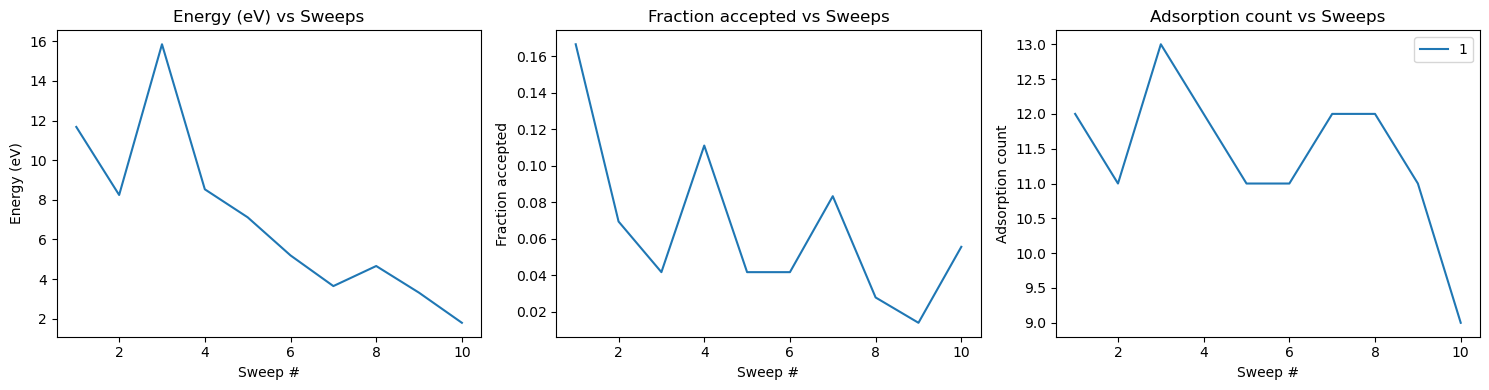

In [5]:
import copy 

run_slab = copy.deepcopy(slab_batch)

mcmc = MCMC(
    calc=nff_calc,
    canonical=False,
    testing=False,
    surface_name=surface_name,
    element=element,
    adsorbates=adsorbates,
    ads_coords=ads_positions,
    relax=relax,
    offset=offset,
    offset_data=offset_data,
    relax_steps=relax_steps,
    optimizer=optimizer
)

start = perf_counter()
# call the main function
mcmc.mcmc_run(num_sweeps=num_sweeps,
    temp=temp,
    pot=chem_pot,
    alpha=alpha,
    slab=run_slab
    )

stop = perf_counter()
print(f"Time taken = {stop - start} seconds")